$$
{\huge \textbf{Dark-Fiber Charakterisierung}}\\
$$

$$
{\huge \textbf{für entanglement polarisierter QKD}}\\ 
$$

$$
{\normalsize \textbf{Aufbereitung und Analyse der Messdaten nach Tageszyklen}}
$$

**Autor:** Laura Komma  
**Datensatz:** Erfurt - Sundhausen

# Aufbereitung der Messdaten
## Ressourcen und Literatur
- [Messdaten](https://www.transfernow.net/dl/20250819MaLA5gU4/lQKfT9vG)
- [Messgerät](https://www.thorlabs.com/_sd.cfm?fileName=MTN007790-D02.pdf&partNumber=PAX1000IR2/M)
- [Plotting-Tool "py_pol"](https://py-pol.readthedocs.io/en/master/index.html)

## Verwendete Libraries / Softwaretools

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import io
import datetime
from IPython.display import Image

from scipy.stats import norm
from scipy.signal import butter, filtfilt

from py_pol.jones_vector import Jones_vector, degrees
from py_pol.stokes import Stokes

## Eigene Hilfsfunktionen

In [3]:
def format_time(x, pos):
    h = int(x) // 3600
    m = (int(x) % 3600) // 60
    return f"{h:02d}:{m:02d}"

In [4]:
def lowpass(data, box = 100):
    box = box
    LP_filter = np.full(int(box), 1/box) 
    lps = np.convolve(ydata, LP_filter)
    lps = lps[ int((box-1) / 2) :len(lps) - int((box - 1) / 2)]
    return lps

def highpass(data, box = 100):
    lps = lowpass(data, box)
    hps = data - lps[:-1]
    return hps

In [6]:
def butter_filter(data, cutoff, fs=4, order=4, btype='low'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = filtfilt(b, a, data)
    return y

In [7]:
def convert_angel(az, el):
    az = np.array(az) * degrees
    el = np.array(el) * degrees
    
    x = np.cos(2*el) * np.cos(2*az)
    y = np.cos(2*el) * np.sin(2*az)
    z = np.sin(2*el)
    return x, y, z

In [8]:
def calculate_freq(x, y, z):
    bins = 50
    coords = np.vstack((x, y, z)).T
    hist, edges = np.histogramdd(coords, bins=bins)

    # Indices for each coordinate pair (with clipping)
    bin_indices = [
        np.clip(np.digitize(x, edges[0]) - 1, 0, bins - 1),
        np.clip(np.digitize(y, edges[1]) - 1, 0, bins - 1),
        np.clip(np.digitize(z, edges[2]) - 1, 0, bins - 1)
    ]
    freq = hist[bin_indices[0], bin_indices[1], bin_indices[2]]
    
    return freq

In [9]:
def plot_poincare(x, y, z, freq, elev=15, azim=45, title="Not given"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Poincaré-Sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v))
    Z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.1, edgecolor='k', linewidth=0.5)

    # Axes
    ax.plot([0, 1.6], [0, 0], [0, 0], color='red')     # +S1
    ax.plot([0, -1.6], [0, 0], [0, 0], color='red')    # -S1
    ax.plot([0, 0], [0, 1.6], [0, 0], color='green')   # +S2
    ax.plot([0, 0], [0, -1.6], [0, 0], color='green')  # -S2
    ax.plot([0, 0], [0, 0], [0, 1.4], color='blue')    # +S3
    ax.plot([0, 0], [0, 0], [0, -1.4], color='blue')   # -S3

    # Labeling Axes
    ax.text( 2.0, 0, 0,  'S1',  color='red', fontsize=10)
    ax.text(-1.8, 0, 0, '-S1',  color='red', fontsize=10)
    ax.text( 0, 1.8, 0,  'S2',  color='green', fontsize=10)
    ax.text( 0, -2.0, 0, '-S2',  color='green', fontsize=10)
    ax.text( 0, 0, 1.6, 'S3',   color='blue', fontsize=10)
    ax.text( 0, 0, -1.6, '-S3',  color='blue', fontsize=10)

    # Measurement
    sc = ax.scatter(x, y, z, c=freq, cmap='hot', s=15)
    plt.colorbar(sc, label='density')

    # Scaling
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

    # Aligning Poincaré-Sphere
    ax.view_init(elev=elev, azim=azim)
    
    ax.set_title(title)

    plt.show()

## Datenaufbereitungsschritte

In [10]:
filename ='20_02_to_26_02_Sundhausen to FZE port 2.csv'
skip = 8
sep = ";"

In [18]:
columns = ['Time[date hh:mm:ss] ', ' Elapsed Time [hh:mm:ss:ms]', ' Normalized s 1 ', ' Normalized s 2 ', ' Normalized s 3 ', ' S 0 [mW]', ' S 1 [mW]', ' S 2 [mW]', ' S 3 [mW]', ' Azimuth[°] ', ' Ellipticity[°] ', ' DOP[%] ', ' DOCP[%] ', ' DOLP[%] ', ' Power[mW] ', ' Pol Power[mW] ', ' Unpol Power[mW] ', ' Power[dBm] ', ' Pol Power[dBm] ', ' Unpol Power[dBm] ', ' Power-Split-Ratio ', ' Phase Difference[°] ', ' Warning']
for c in range(len(columns)):
    print(c, ': ', columns[c])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]

0 :  Time[date hh:mm:ss] 
1 :   Elapsed Time [hh:mm:ss:ms]
2 :   Normalized s 1 
3 :   Normalized s 2 
4 :   Normalized s 3 
5 :   S 0 [mW]
6 :   S 1 [mW]
7 :   S 2 [mW]
8 :   S 3 [mW]
9 :   Azimuth[°] 
10 :   Ellipticity[°] 
11 :   DOP[%] 
12 :   DOCP[%] 
13 :   DOLP[%] 
14 :   Power[mW] 
15 :   Pol Power[mW] 
16 :   Unpol Power[mW] 
17 :   Power[dBm] 
18 :   Pol Power[dBm] 
19 :   Unpol Power[dBm] 
20 :   Power-Split-Ratio 
21 :   Phase Difference[°] 
22 :   Warning


# Polarisationsgrad (DOP [%])

In [12]:
degree = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[11]])

In [13]:
degree[columns[0]] = pd.to_datetime(degree[columns[0]])
degree.set_index(columns[0], inplace=True)

## Tägliche Aufteilung der Messdaten

In [14]:
degree_daily = degree.groupby(degree.index.date)
degree_daily_list = list(degree_daily)

In [15]:
for date, df_day in degree_daily_list:
    print(date, '\n')
    print(df_day.describe())
    print('')

2025-02-20 

             DOP[%] 
count  148479.000000
mean      100.027175
std         5.031556
min        72.420000
25%        97.480000
50%        99.770000
75%       102.400000
max       141.730000

2025-02-21 

             DOP[%] 
count  338320.000000
mean       99.089434
std         5.499147
min        69.580000
25%        96.310000
50%        98.760000
75%       101.600000
max       136.480000

2025-02-22 

             DOP[%] 
count  338429.000000
mean      100.040453
std         6.156741
min        66.290000
25%        96.840000
50%        99.810000
75%       103.230000
max       138.270000

2025-02-23 

             DOP[%] 
count  338655.000000
mean      100.177322
std         5.167570
min        70.560000
25%        97.500000
50%        99.760000
75%       102.520000
max       132.930000

2025-02-24 

             DOP[%] 
count  338847.000000
mean      100.474675
std         7.045158
min        58.560000
25%        97.210000
50%        99.900000
75%       103.300000
max    

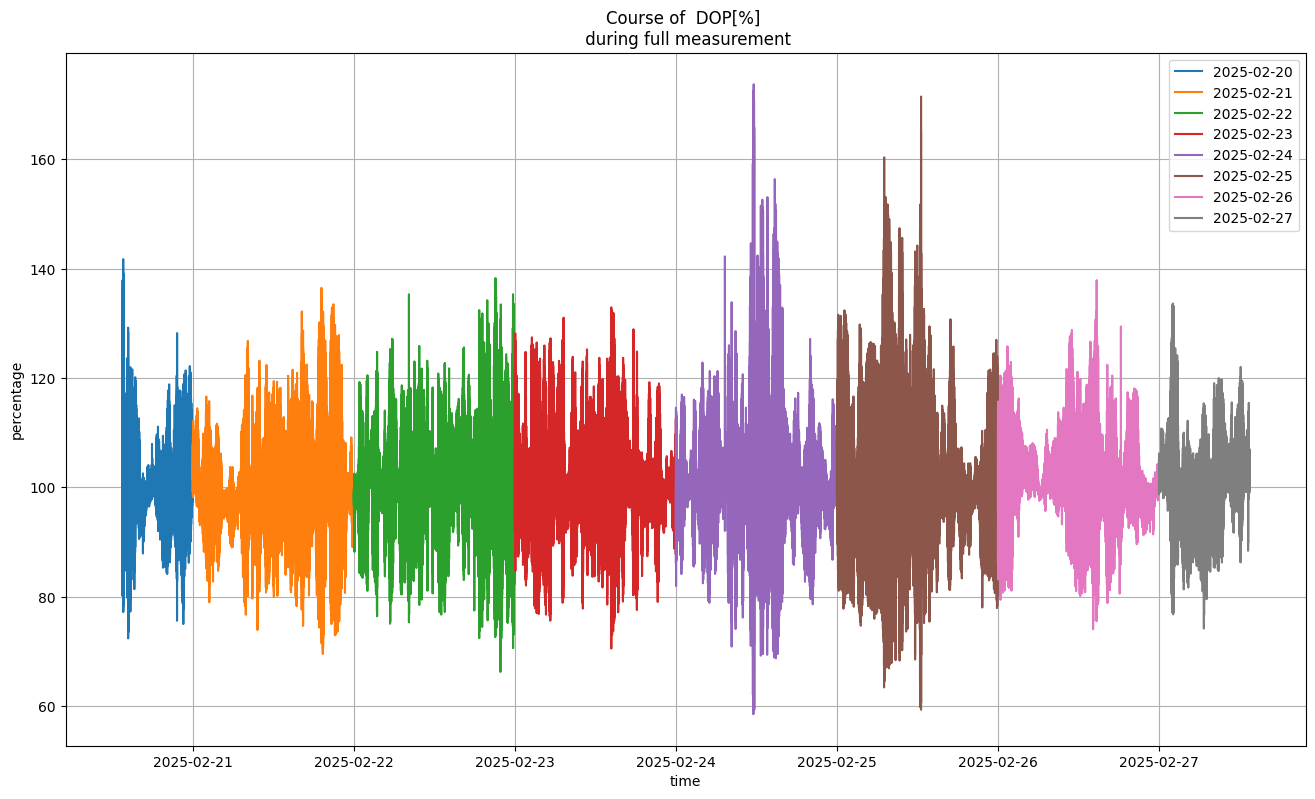

In [19]:
plt.figure(figsize = (16,9))
for date, df_day in degree_daily_list:
    values = df_day
    plt.plot(values, label=str(date))
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[11]}\n during full measurement')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

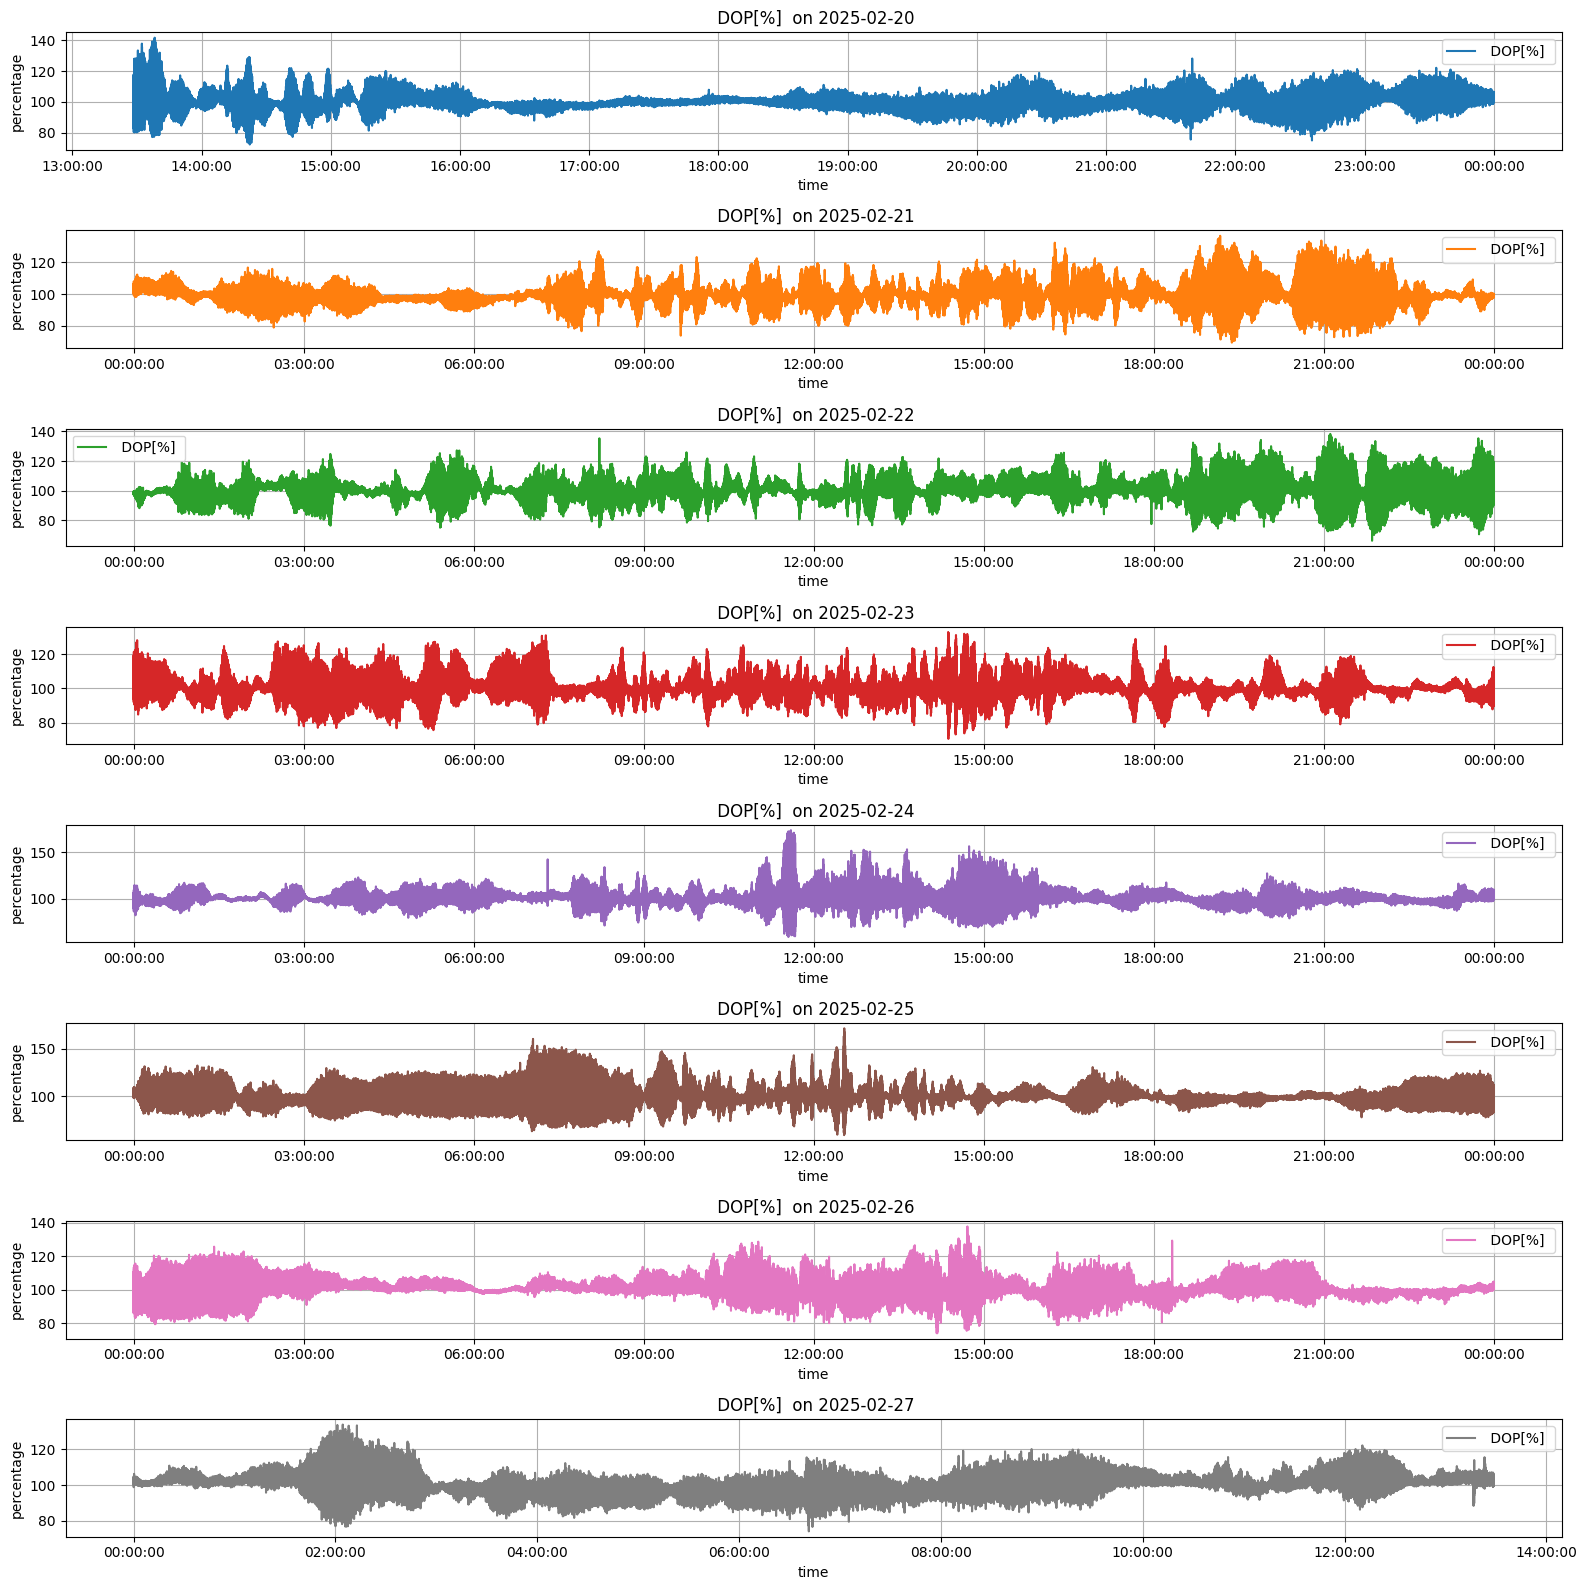

In [20]:
fig, axs = plt.subplots(len(degree_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(degree_daily_list)):
    ax = axs[i] if len(degree_daily_list) > 1 else axs
    df_day = degree_daily_list[i][1]

    ax.plot(df_day.index, df_day, label=columns[11], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[11]} on {degree_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('percentage')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

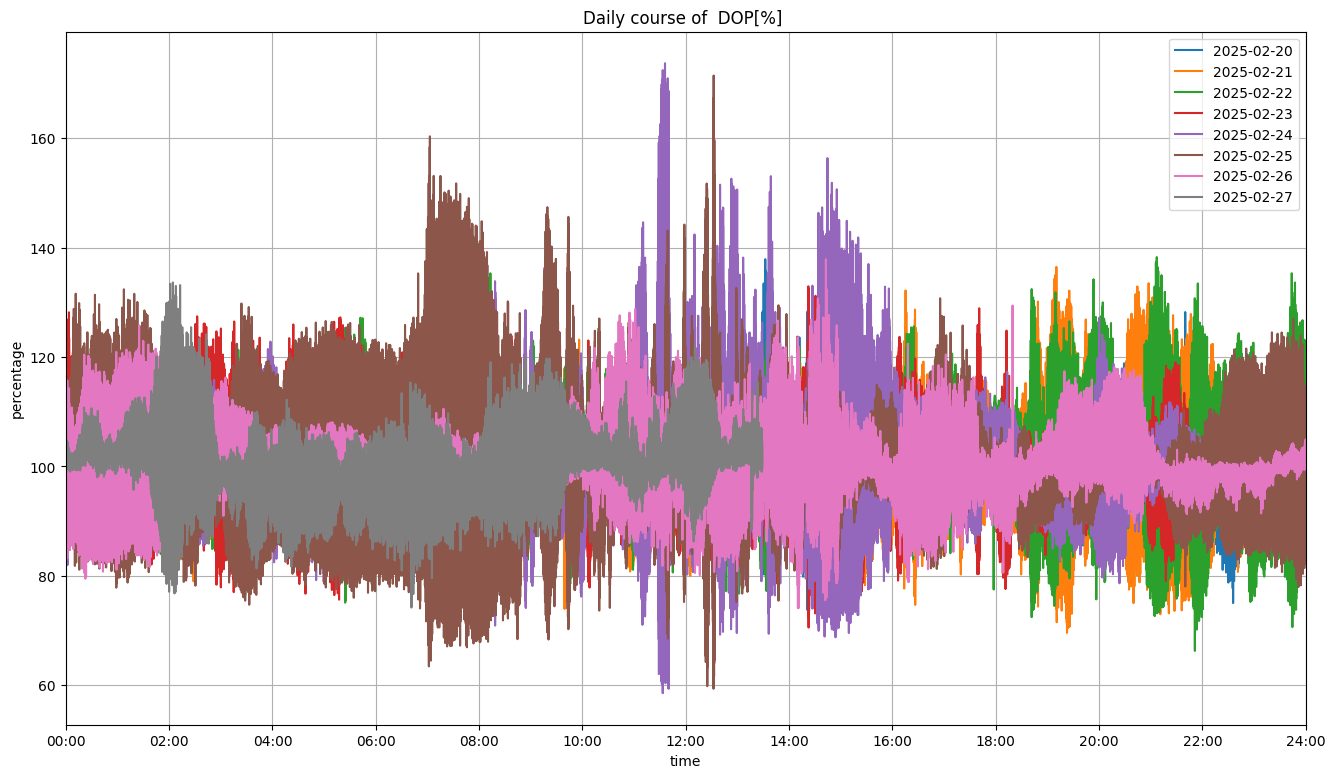

In [21]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    values = df_day
    plt.plot(times, values, label=str(date))
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Daily course of {columns[11]}')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

## Stundenweise Aufteilung (Beispiel: zweiter Tag)

In [30]:
# exemplary day
day = 1 #second day

In [31]:
degree_one_day = degree_daily_list[day][1]
hourly = degree_one_day.groupby(degree_one_day.index.hour)
degree_hourly = list(hourly)

In [32]:
for hour, df_hour in degree_hourly:
    print(f'{hour}:00\n')
    print(df_hour.describe())
    print('')

0:00

            DOP[%] 
count  14084.000000
mean     103.795743
std        2.797892
min       94.740000
25%      101.860000
50%      103.830000
75%      105.810000
max      114.490000

1:00

           DOP[%] 
count  14086.00000
mean      98.75668
std        2.86260
min       86.98000
25%       97.16000
50%       99.13000
75%      100.27000
max      113.86000

2:00

            DOP[%] 
count  14084.000000
mean      96.927555
std        4.610012
min       79.010000
25%       93.640000
50%       96.780000
75%      100.030000
max      116.620000

3:00

            DOP[%] 
count  14086.000000
mean      97.751751
std        3.811546
min       82.810000
25%       95.330000
50%       98.030000
75%      100.320000
max      111.660000

4:00

            DOP[%] 
count  14086.000000
mean      97.392722
std        1.681316
min       88.100000
25%       96.682500
50%       97.340000
75%       98.010000
max      106.230000

5:00

            DOP[%] 
count  14087.000000
mean      96.566923
std     

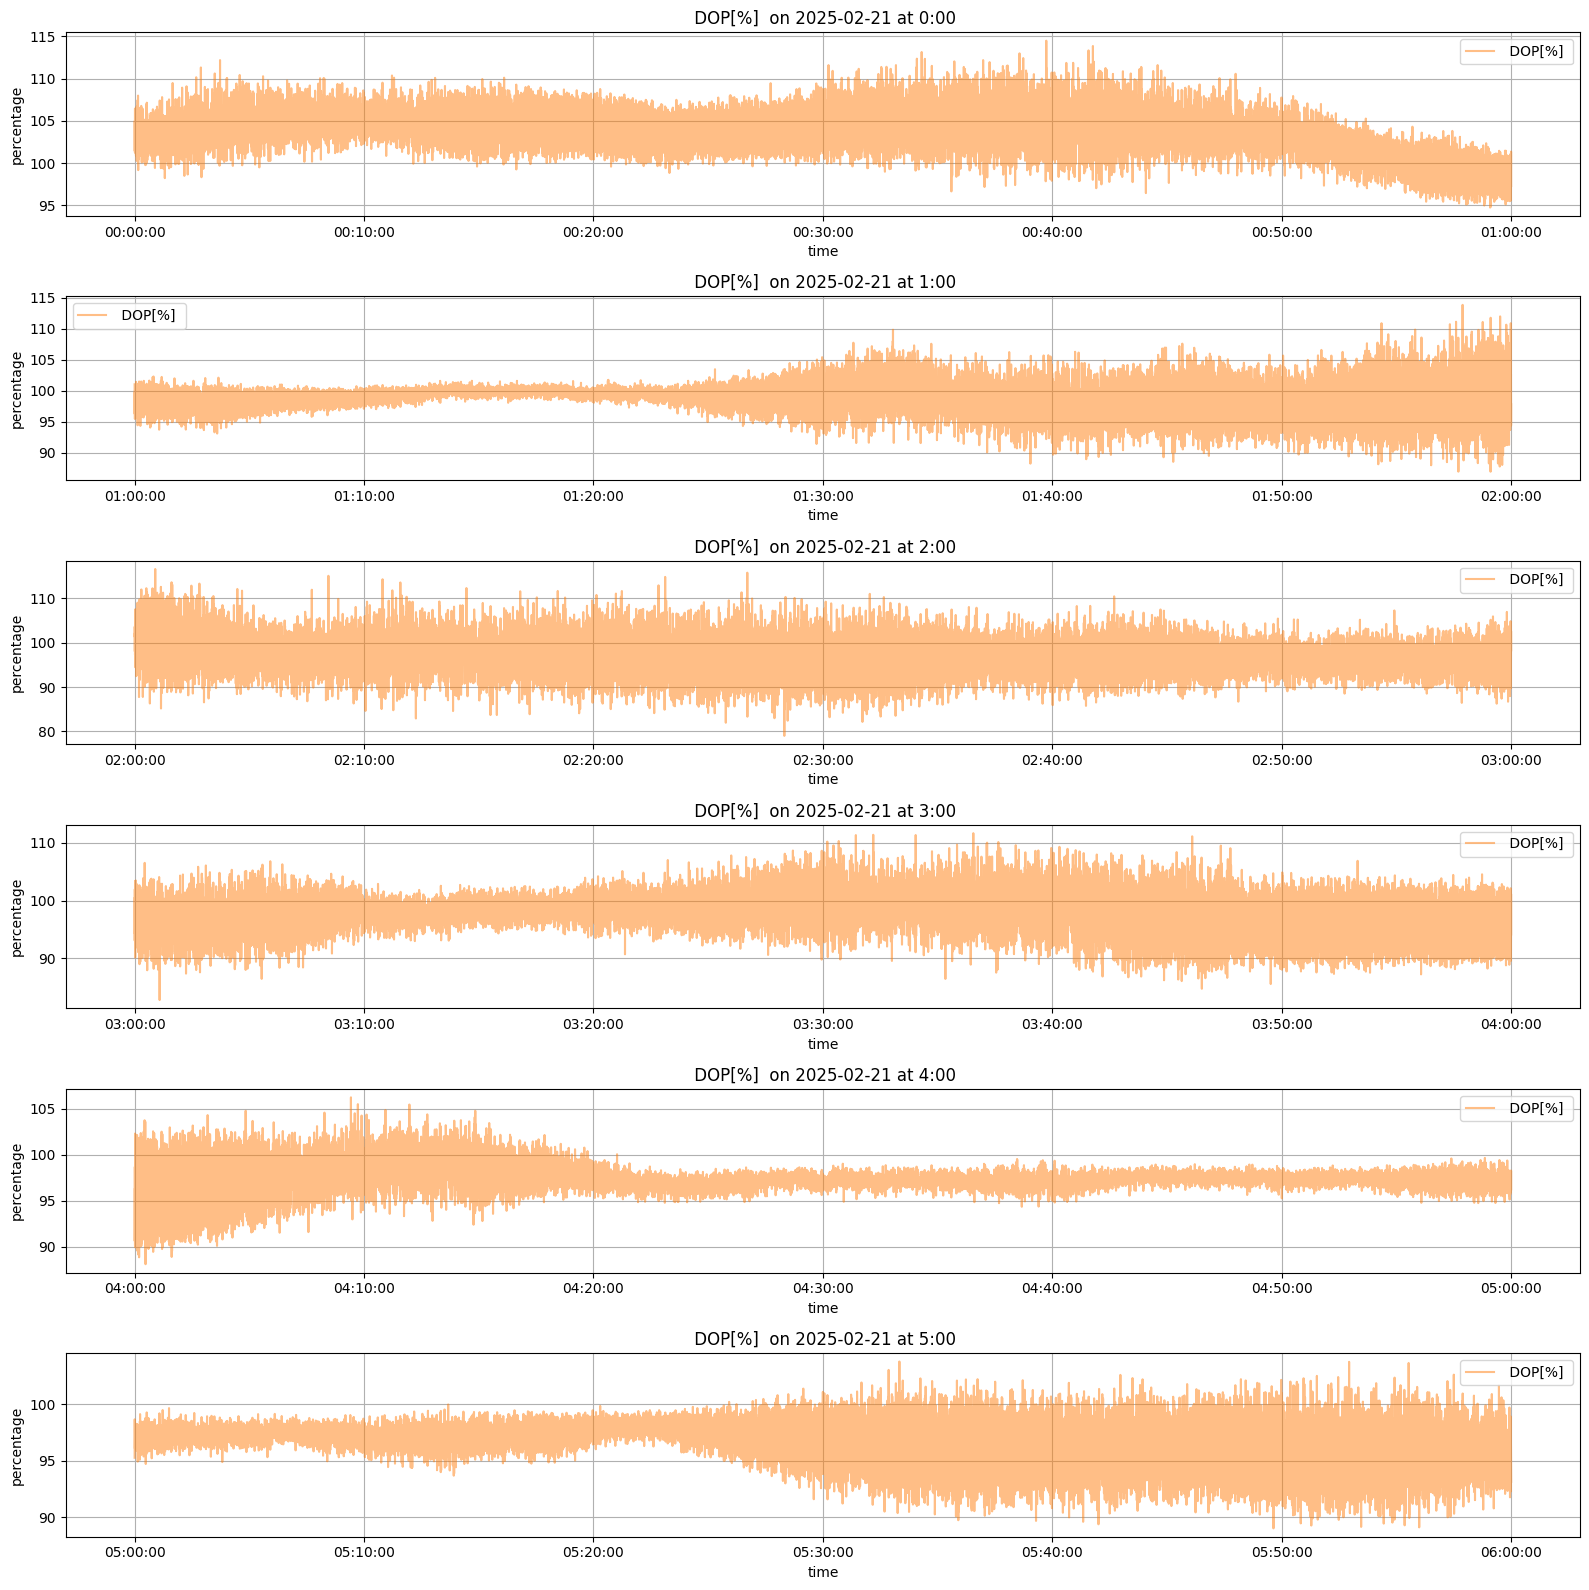

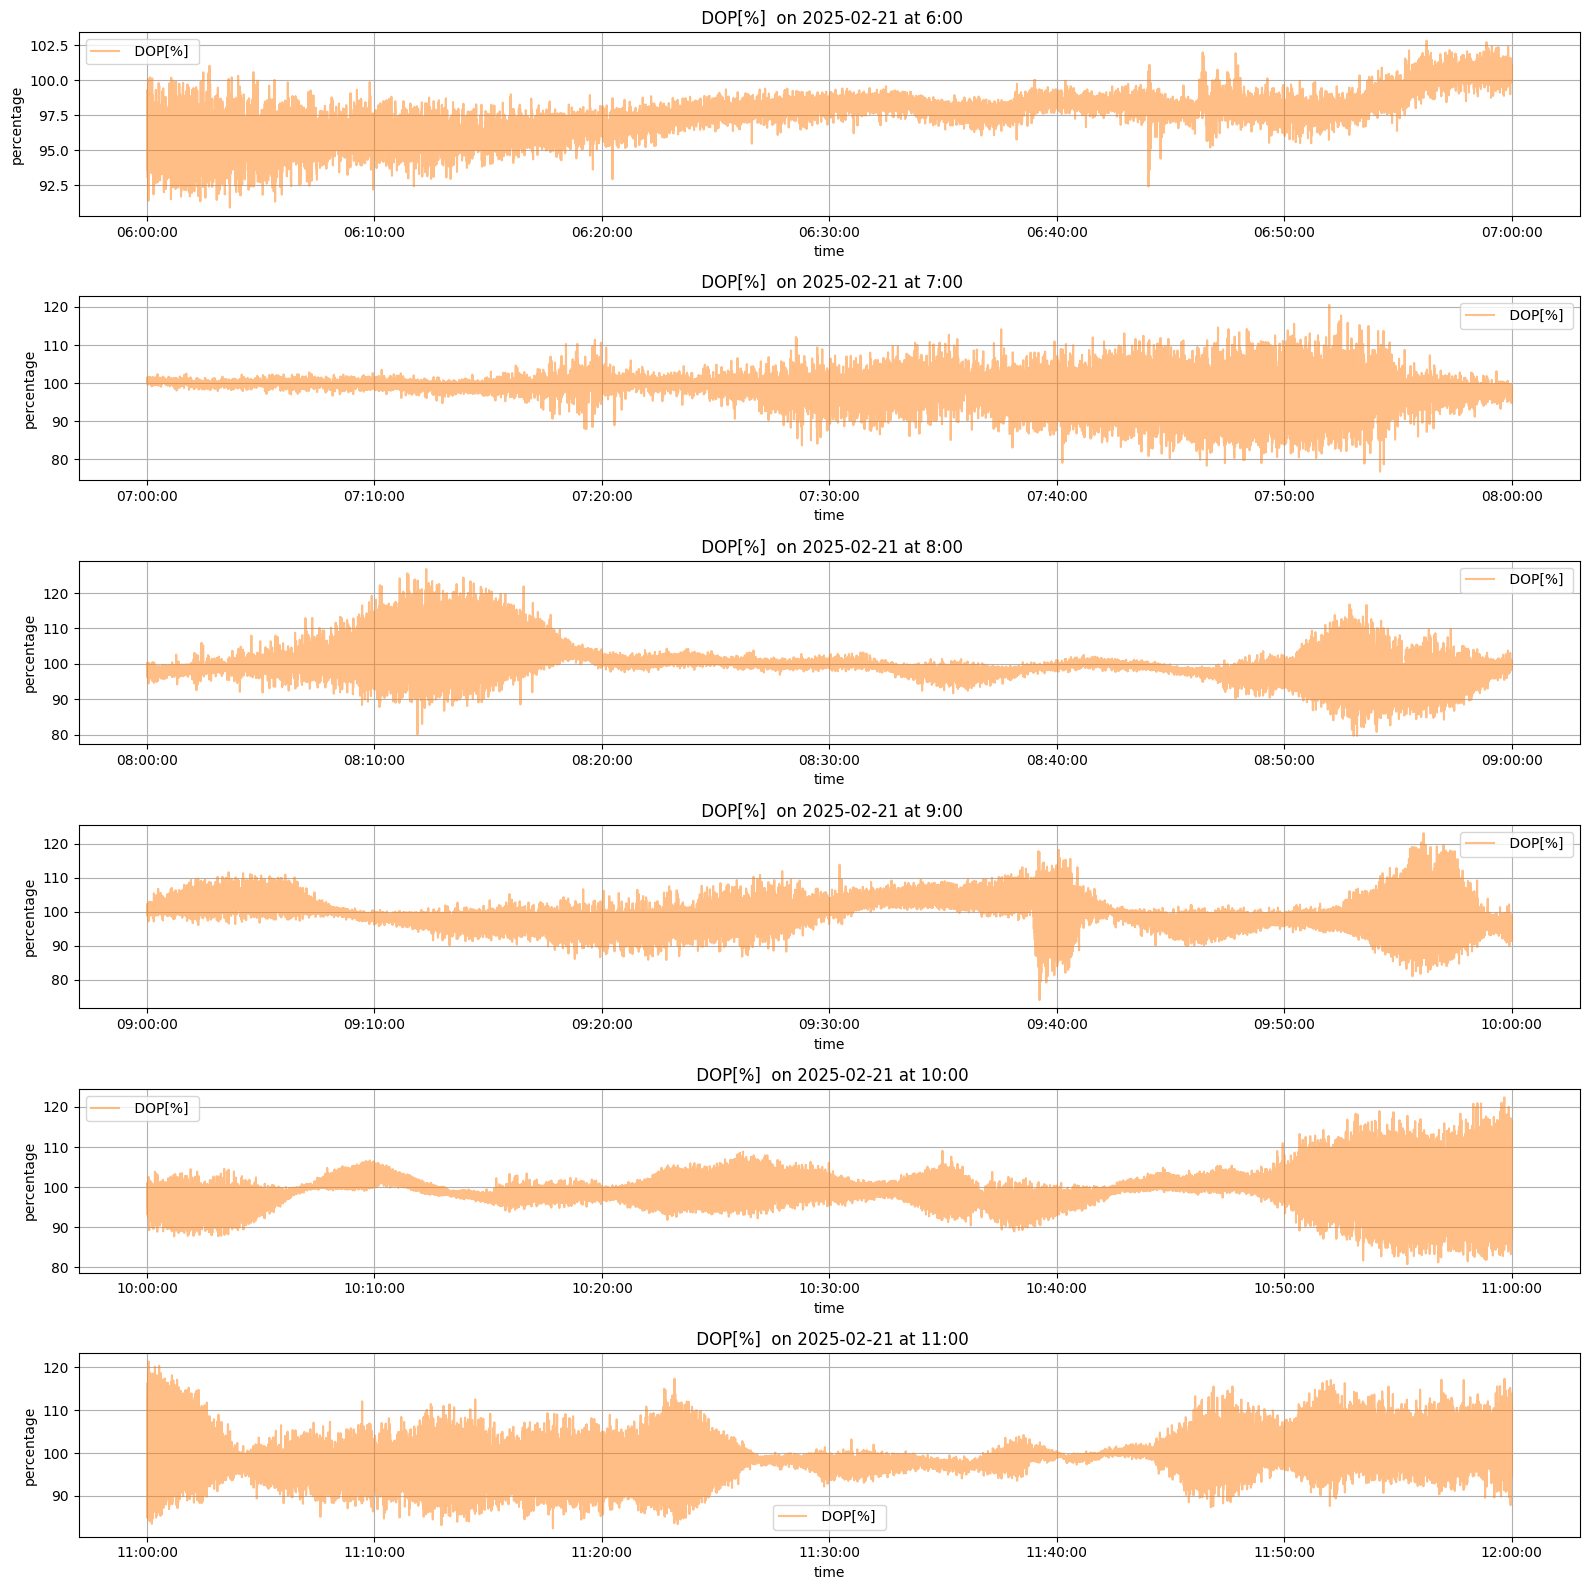

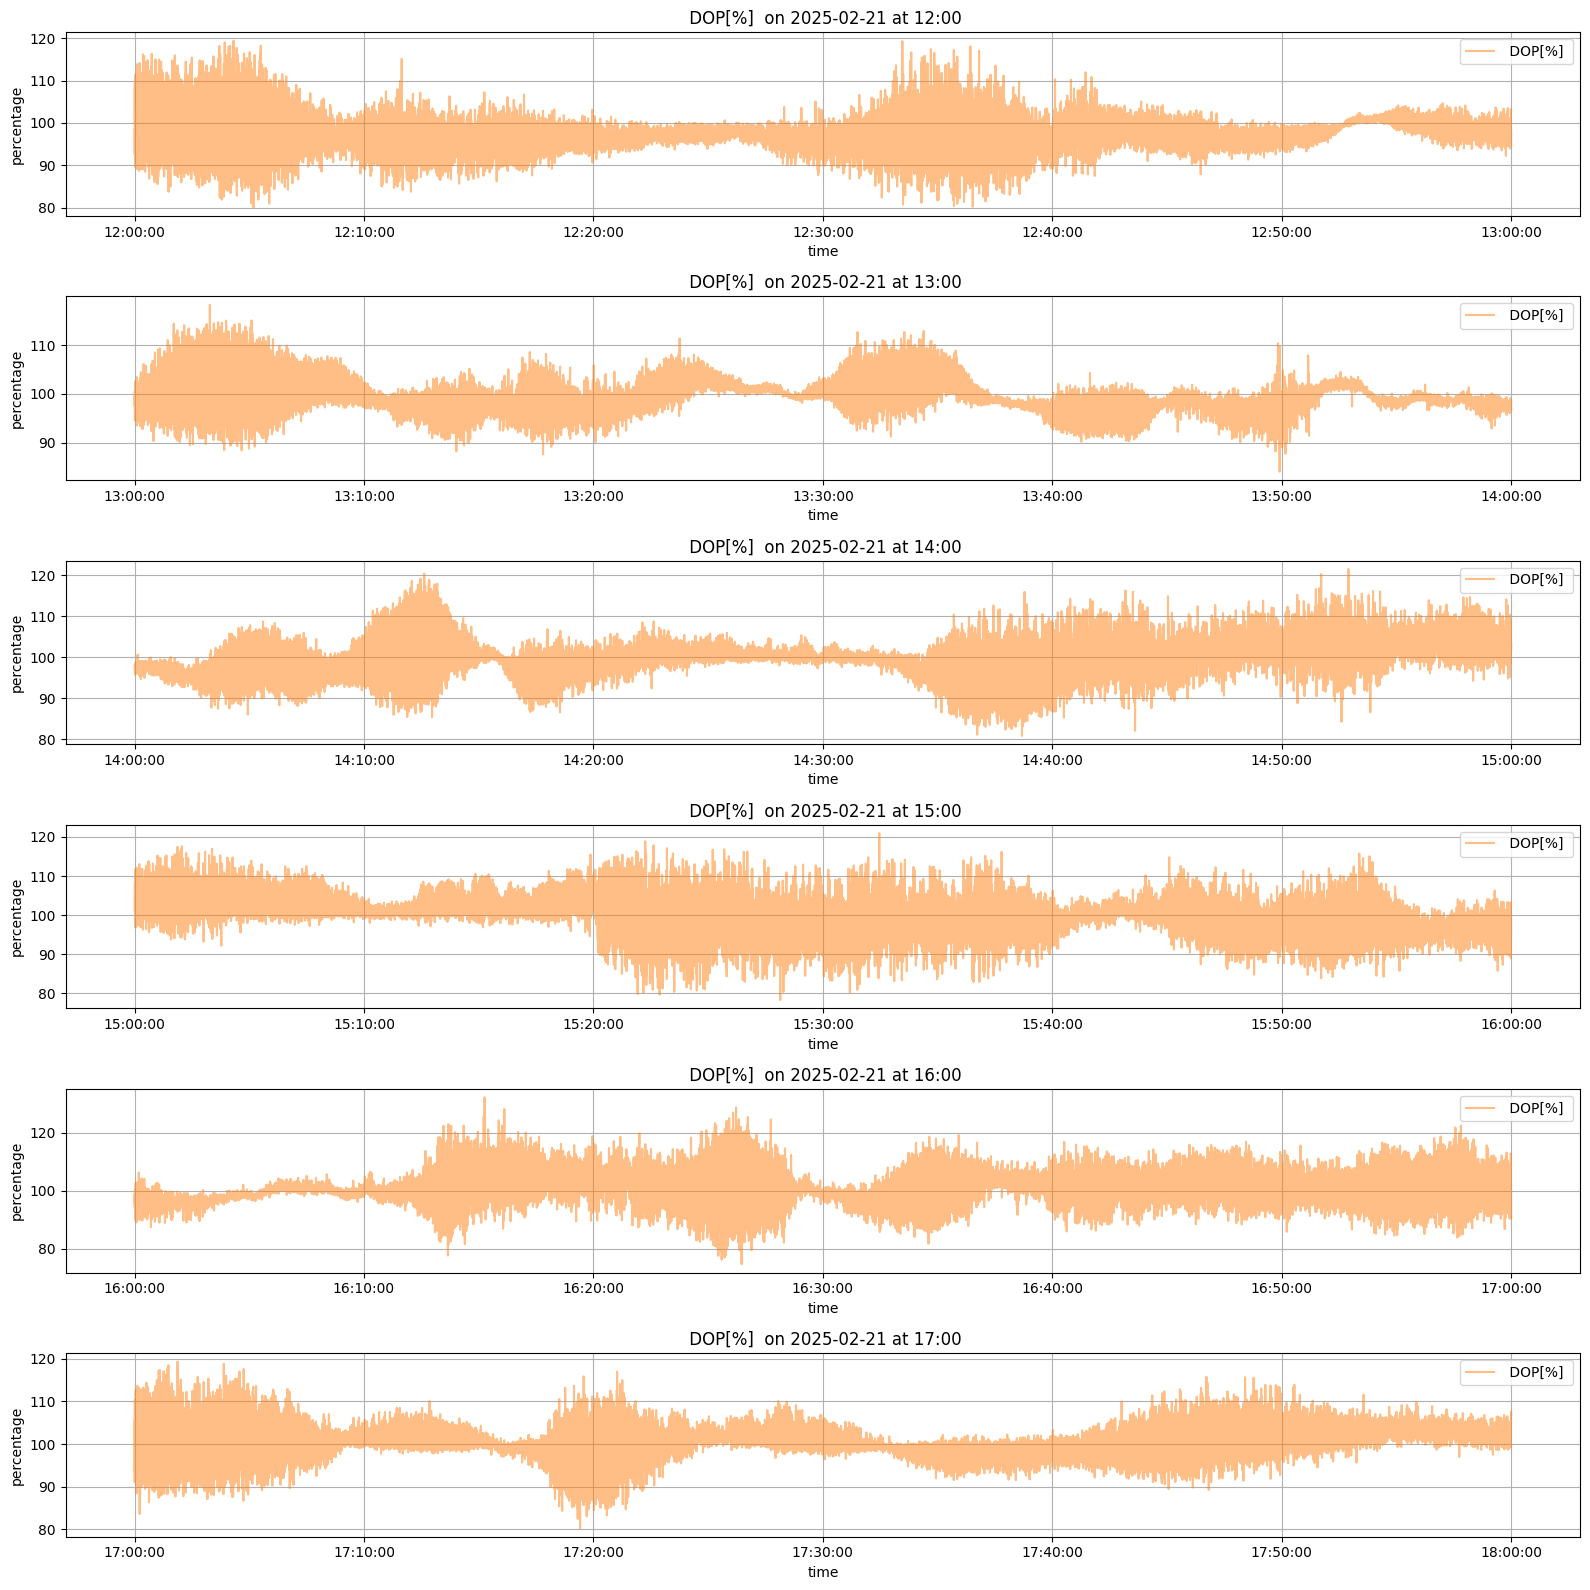

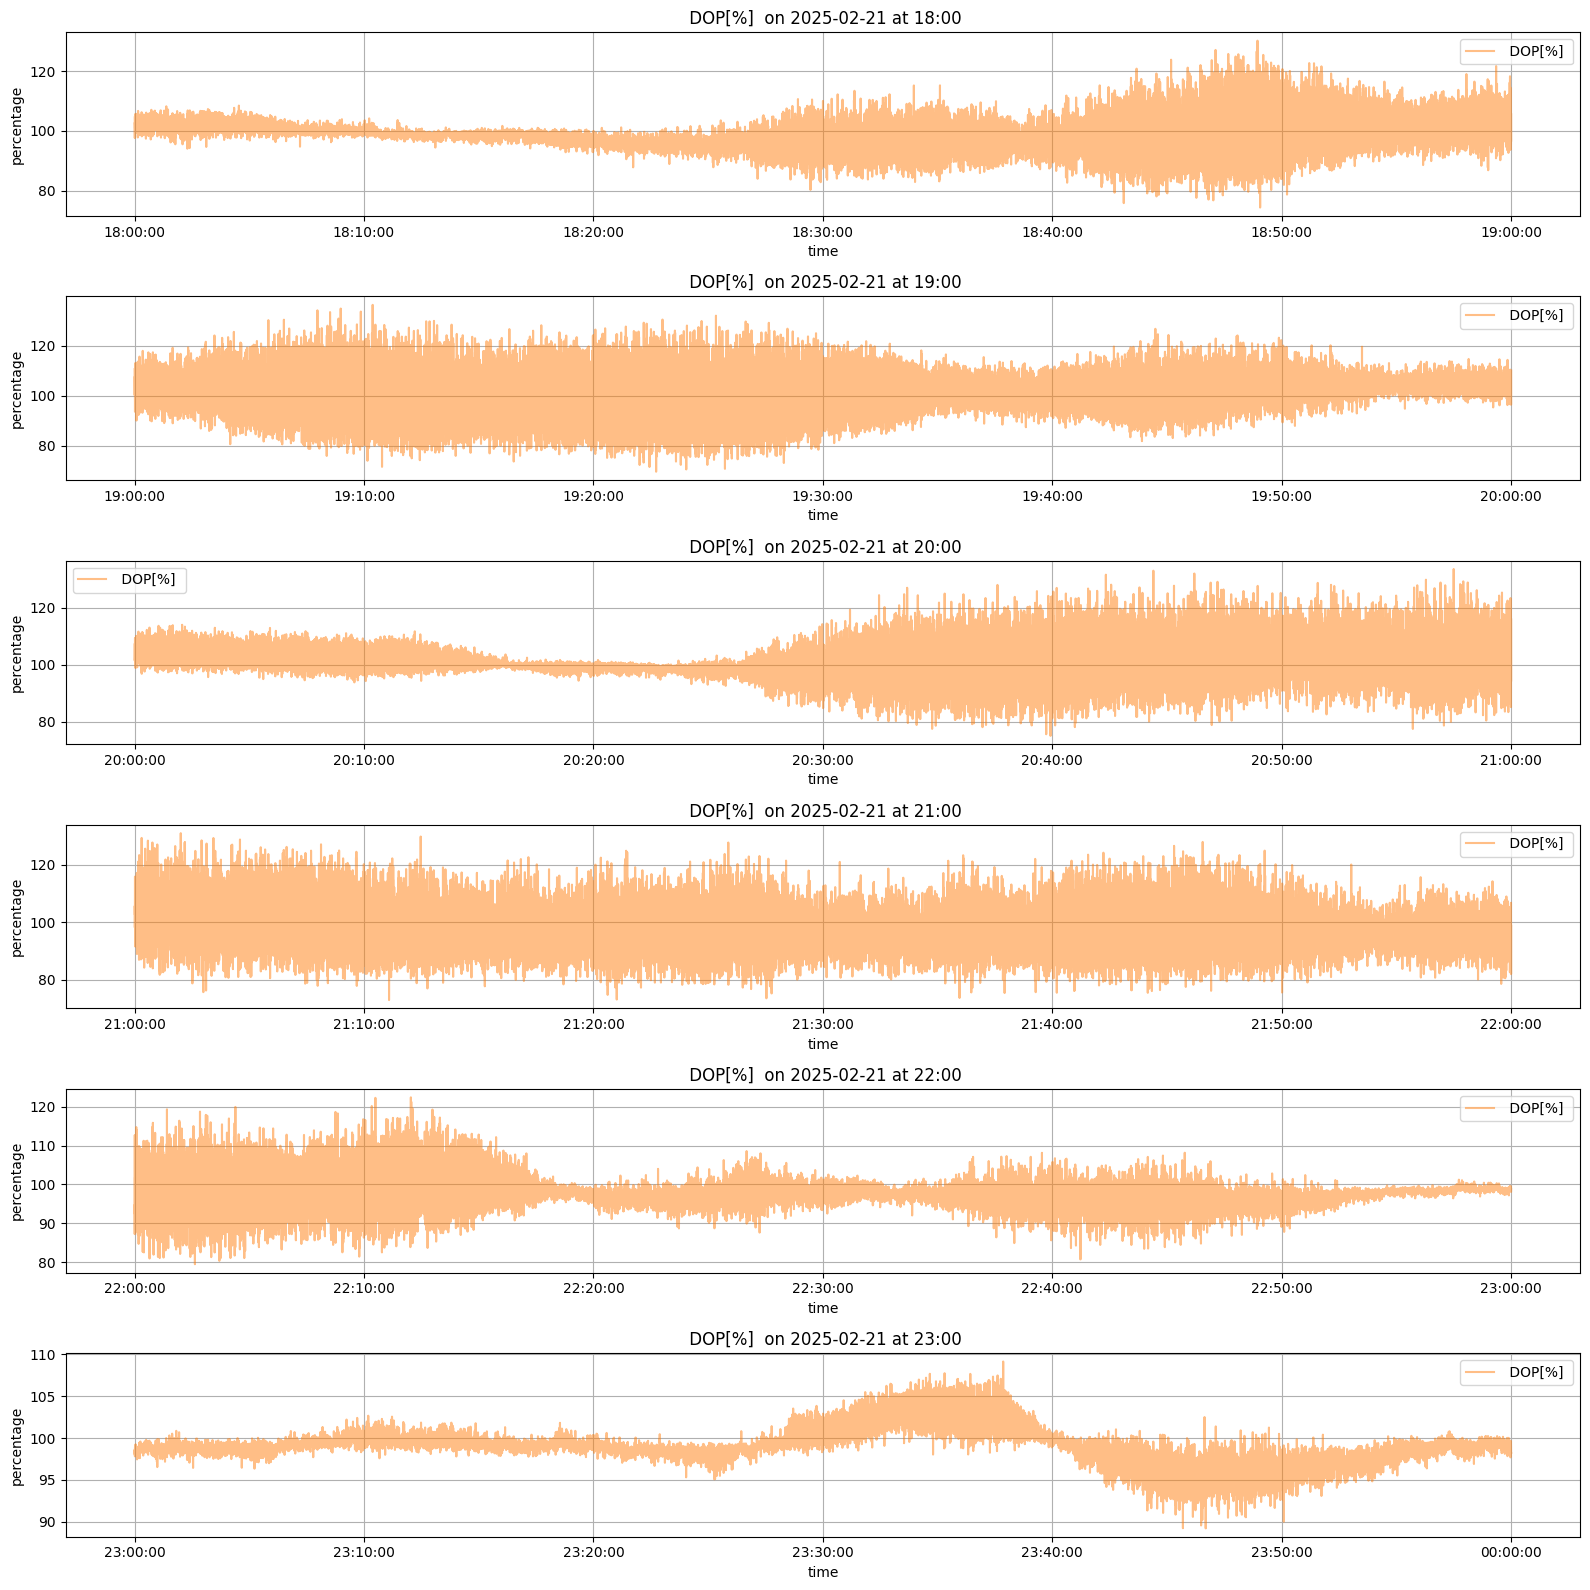

In [33]:
daily_quaters = [degree_hourly[:6], degree_hourly[6:12], degree_hourly[12:18], degree_hourly[18:]]
for quater in daily_quaters:
    fig, axs = plt.subplots(len(quater), 1, figsize=(16, 16), sharex=False)

    for i in range(len(quater)):
        ax = axs[i] if len(quater) > 1 else axs
        df_day = quater[i][1]

        ax.plot(df_day.index, df_day, label=columns[11], color=colors[day], alpha=0.5)
        ax.grid()
        ax.legend(loc='best')
        ax.set_title(f'{columns[11]} on {degree_daily_list[day][0]} at {quater[i][0]}:00')
        ax.set_xlabel('time')
        ax.set_ylabel('percentage')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    plt.tight_layout()
    plt.show()

## Ausreißerbereinigung

In [34]:
new_degree = degree[columns[11]]
new_degree = new_degree.drop(new_degree[(new_degree > 140) | (new_degree < 0)].index)
new_degree.describe()

count    2.368581e+06
mean     1.000677e+02
std      6.286610e+00
min      5.856000e+01
25%      9.693000e+01
50%      9.973000e+01
75%      1.030000e+02
max      1.400000e+02
Name:  DOP[%] , dtype: float64

In [35]:
new_degree_daily = new_degree.groupby(new_degree.index.date)
new_degree_daily_list = list(new_degree_daily)

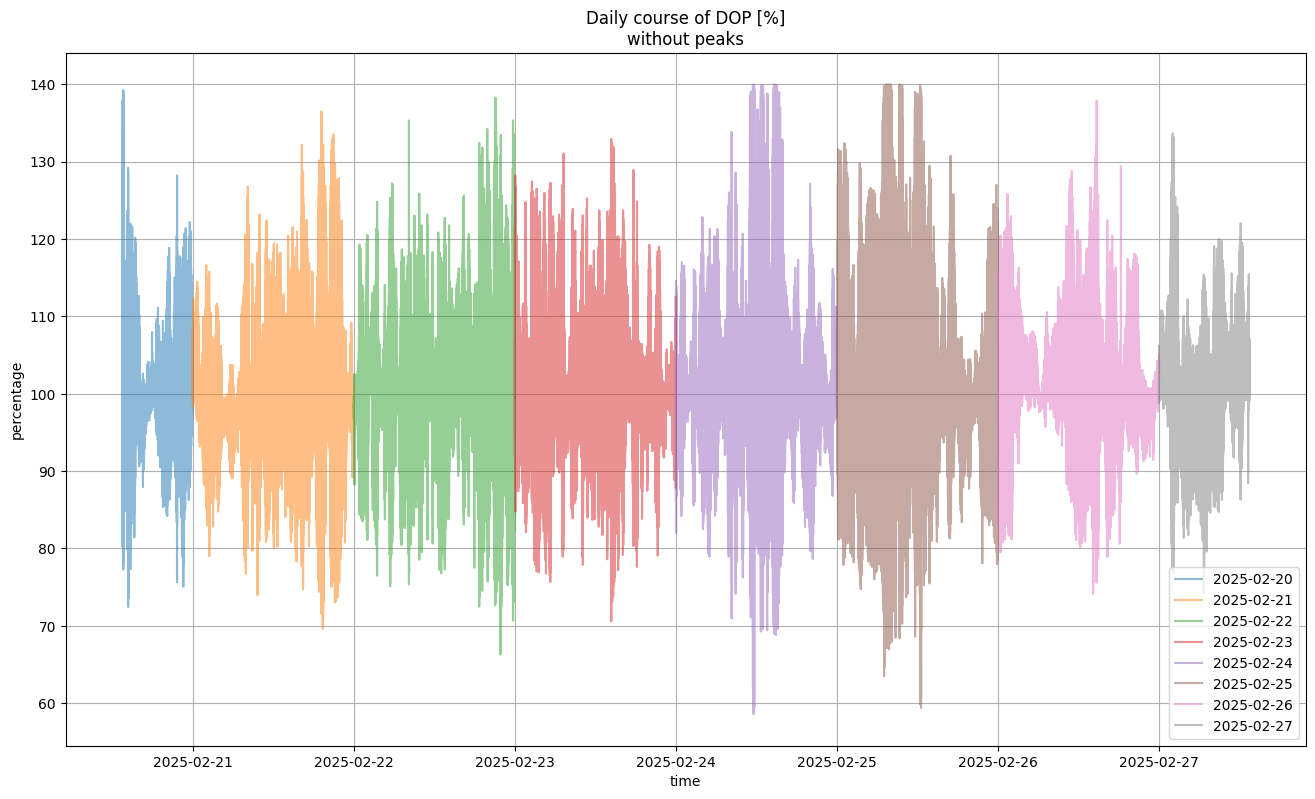

In [36]:
plt.figure(figsize = (16,9))
for date, df_day in new_degree_daily_list:
    values = df_day
    plt.plot(values, label=str(date), alpha = 0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title('Daily course of DOP [%]\nwithout peaks')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

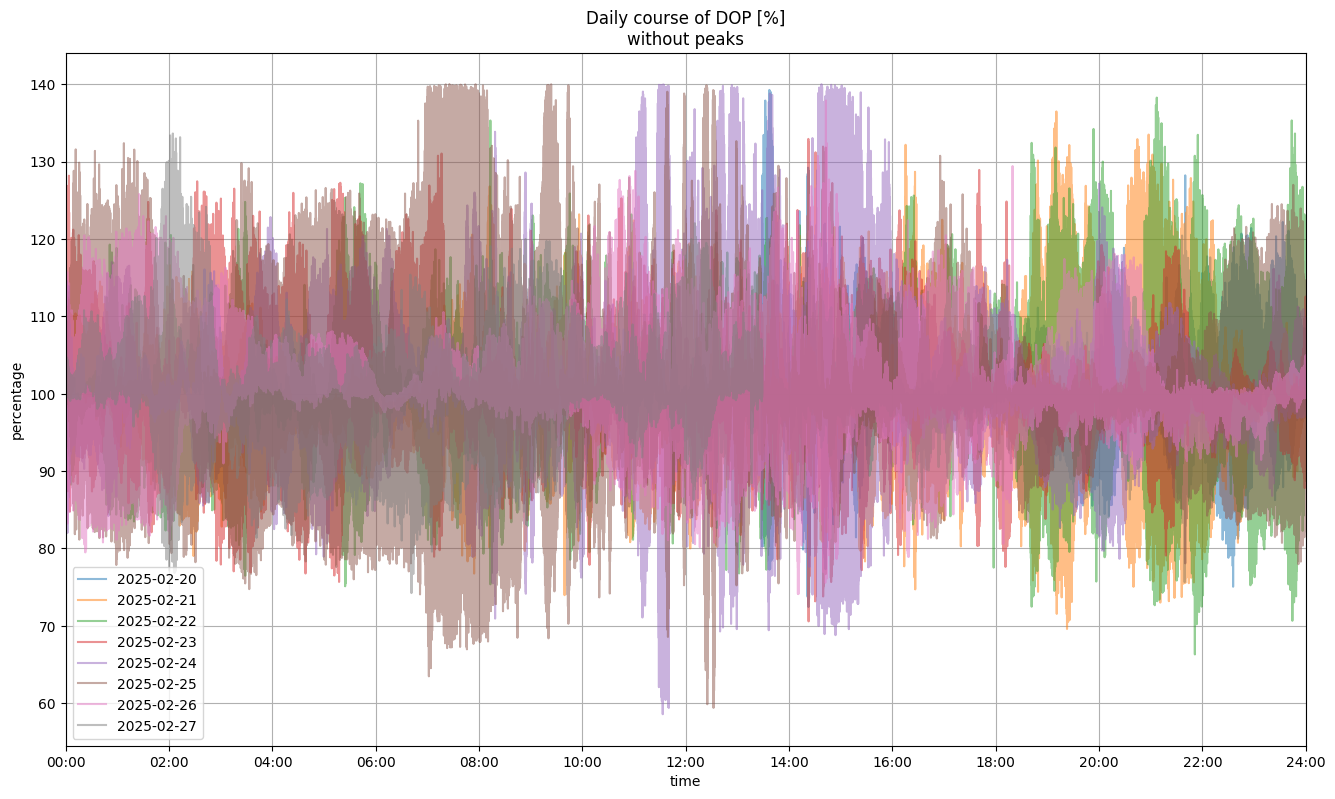

In [37]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    values = df_day
    plt.plot(times, values, label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title('Daily course of DOP [%]\nwithout peaks')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

## Tägliche Normalverteilung mit Histogramm

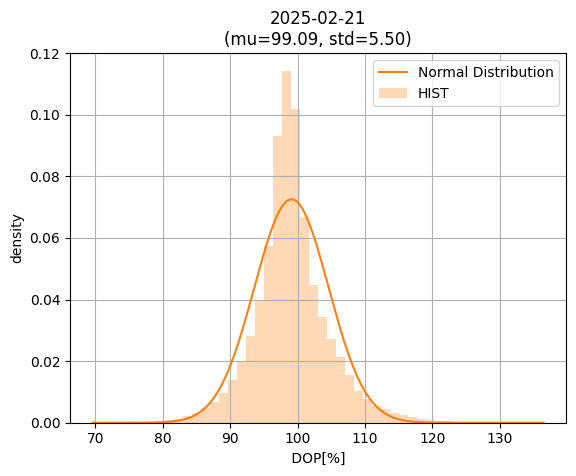

In [38]:
ydata1 = np.array(new_degree_daily_list[day][1])
mu1 = np.mean(ydata1)
sigma1 = np.std(ydata1)
x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
y1 = norm.pdf(x1, mu1, sigma1)  

plt.plot(x1, y1, label = 'Normal Distribution', color=colors[day])
plt.hist(ydata1, bins = 50, density = True, color=colors[day], alpha = 0.3, label = "HIST")

plt.title(f'{new_degree_daily_list[day][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
plt.legend(loc = 'best')
plt.xlabel(columns[11])
plt.ylabel('density')
plt.grid()
plt.show()

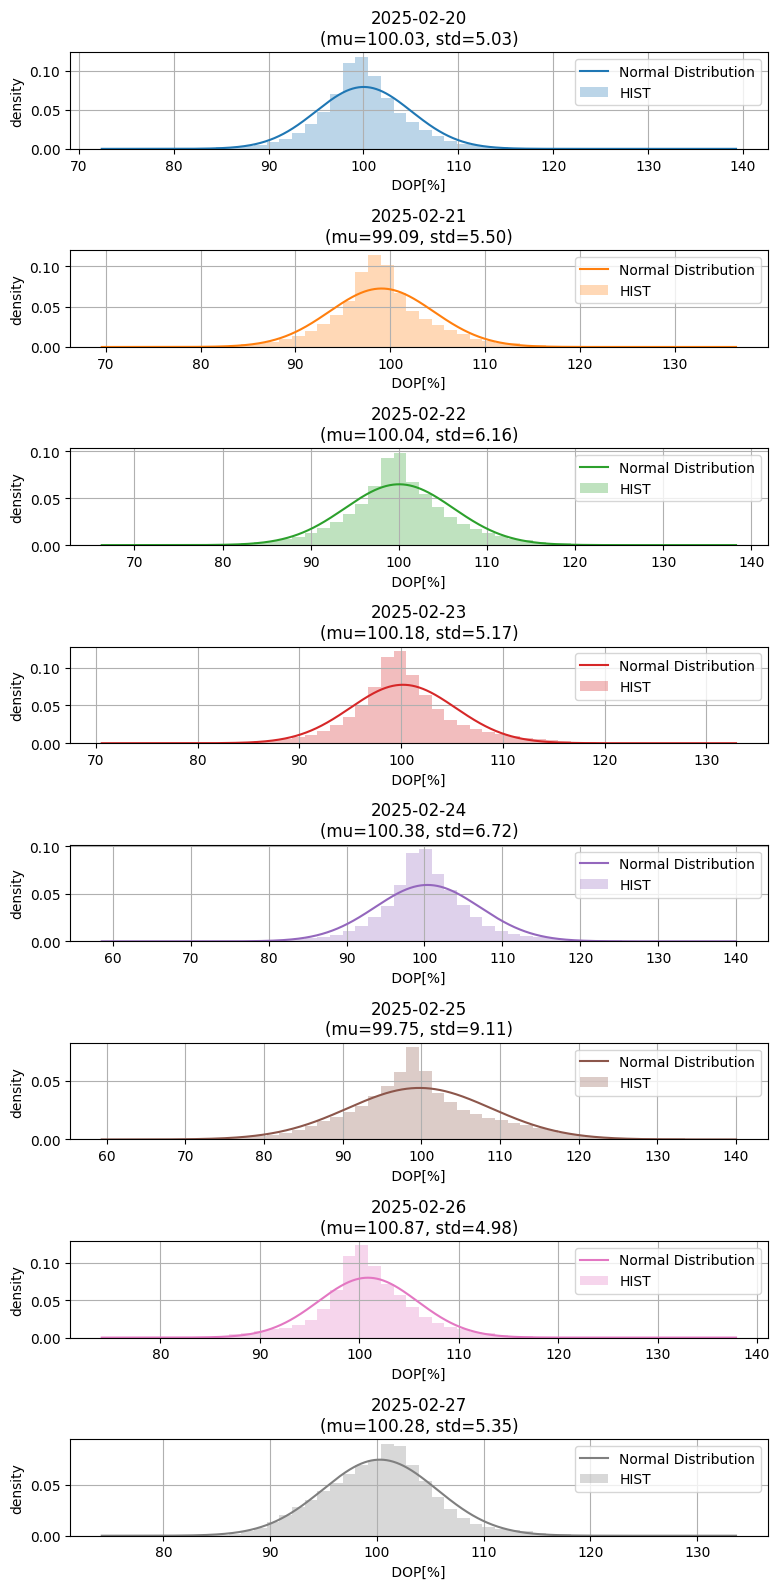

In [39]:
fig, axs = plt.subplots(len(new_degree_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(new_degree_daily_list)):
    ax = axs[i] if len(new_degree_daily_list) > 1 else axs
    ydata1 = np.array(new_degree_daily_list[i][1])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{degree_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[11])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

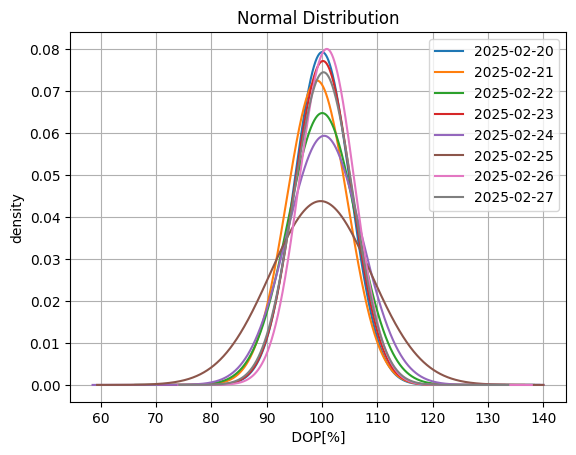

In [40]:
for i in range(len(new_degree_daily_list)):
    ydata1 = np.array(new_degree_daily_list[i][1])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    plt.plot(x1, y1, label = new_degree_daily_list[i][0])
    
plt.title(f'Normal Distribution')
plt.legend(loc = 'best')
plt.xlabel(columns[11])
plt.ylabel('density')
plt.grid()
plt.show()

## Filterung mittels Tief- und Hochpass

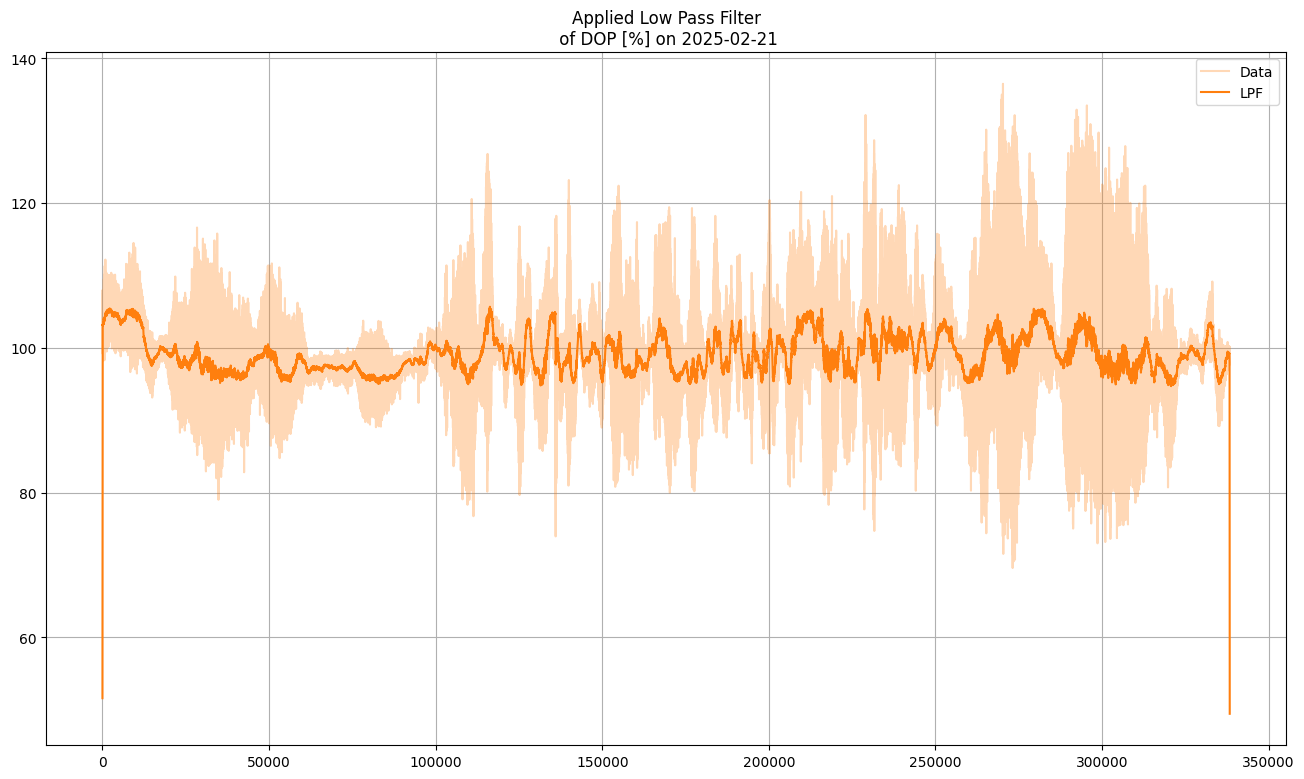

In [41]:
ydata = np.array(new_degree_daily_list[day][1])

lps = lowpass(ydata, 100)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(lps, label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter\n of DOP [%] on {new_degree_daily_list[day][0]}')
plt.grid()
plt.legend(loc = 'best')
plt.show()

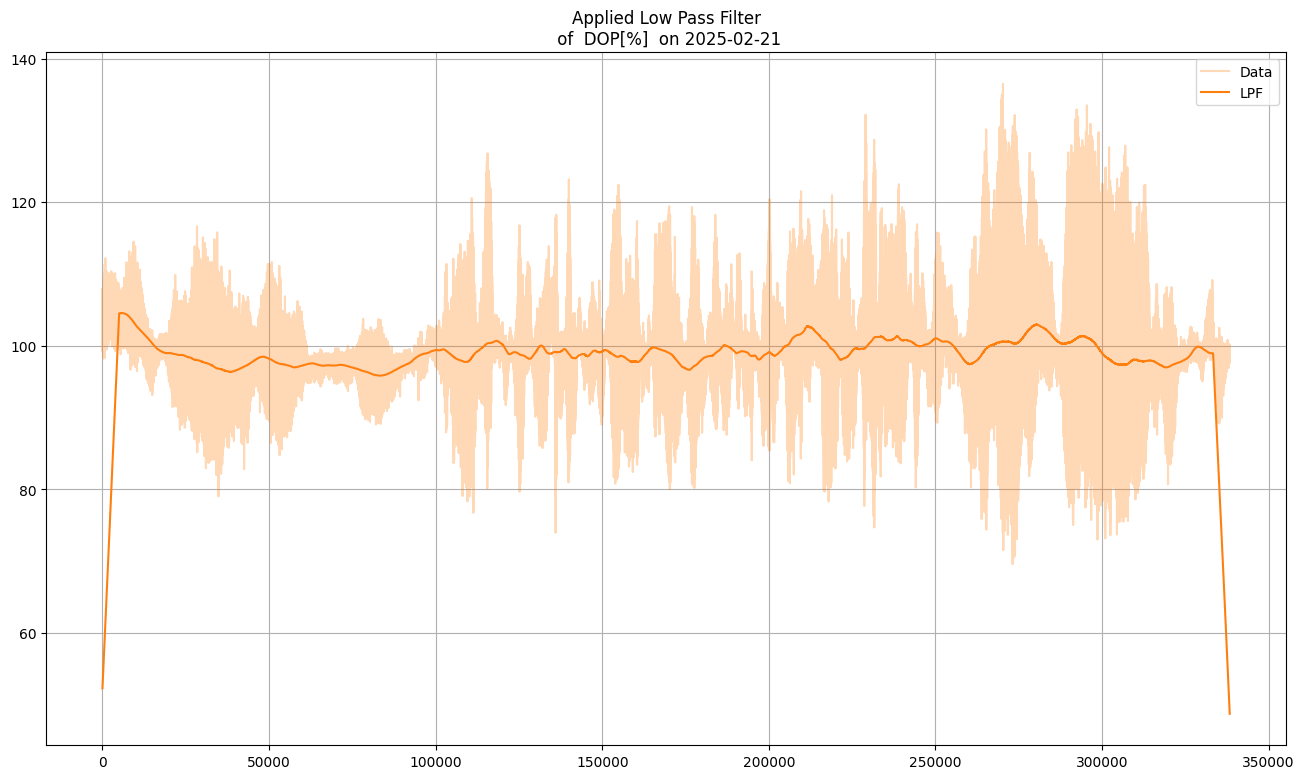

In [42]:
ydata = np.array(new_degree_daily_list[day][1])

lps = lowpass(ydata, 10000)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(lps, label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter\n of {columns[11]} on {new_degree_daily_list[day][0]}')
plt.grid()
plt.legend(loc = 'best')
plt.show()

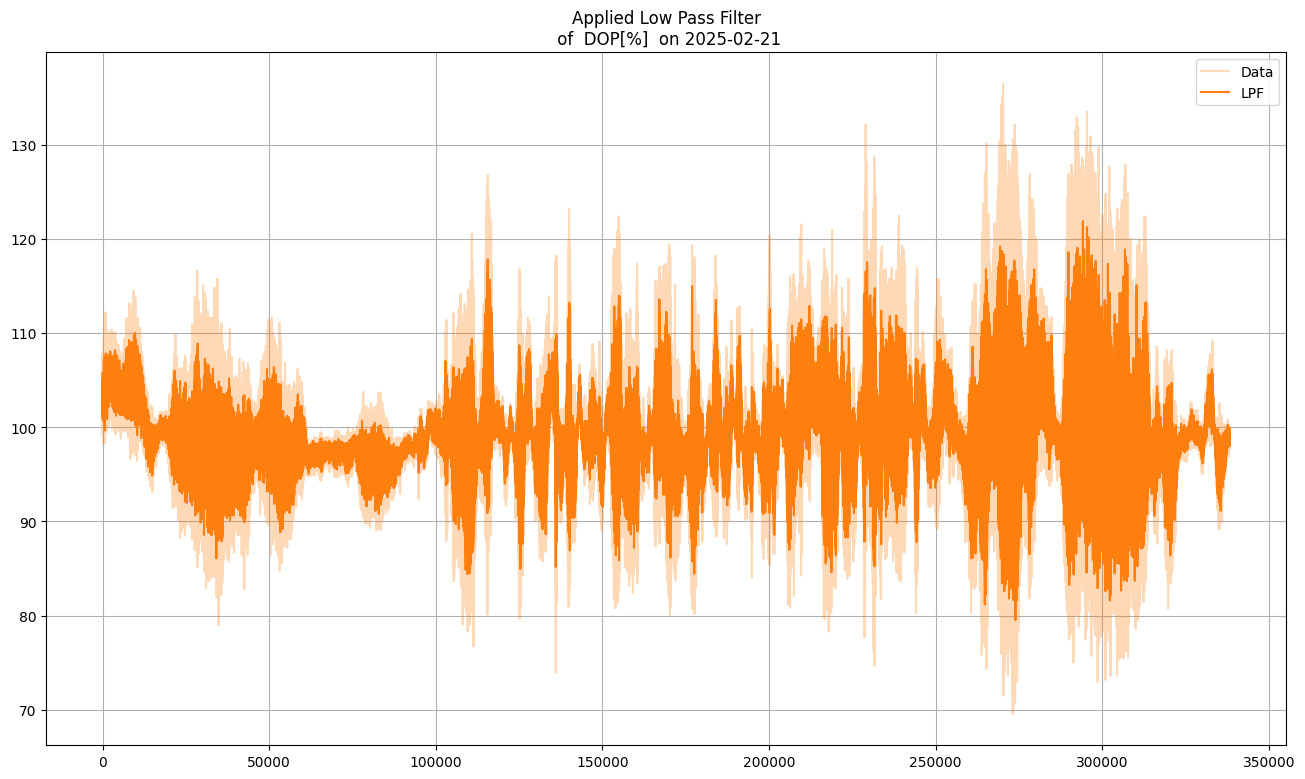

In [43]:
cutoff = 1.0
btype='low'

ydata = np.array(new_degree_daily_list[day][1])
lps = butter_filter(ydata, cutoff = cutoff, btype=btype)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(lps, label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter\n of {columns[11]} on {new_degree_daily_list[day][0]}')
plt.grid()
plt.legend(loc = 'best')
plt.show()

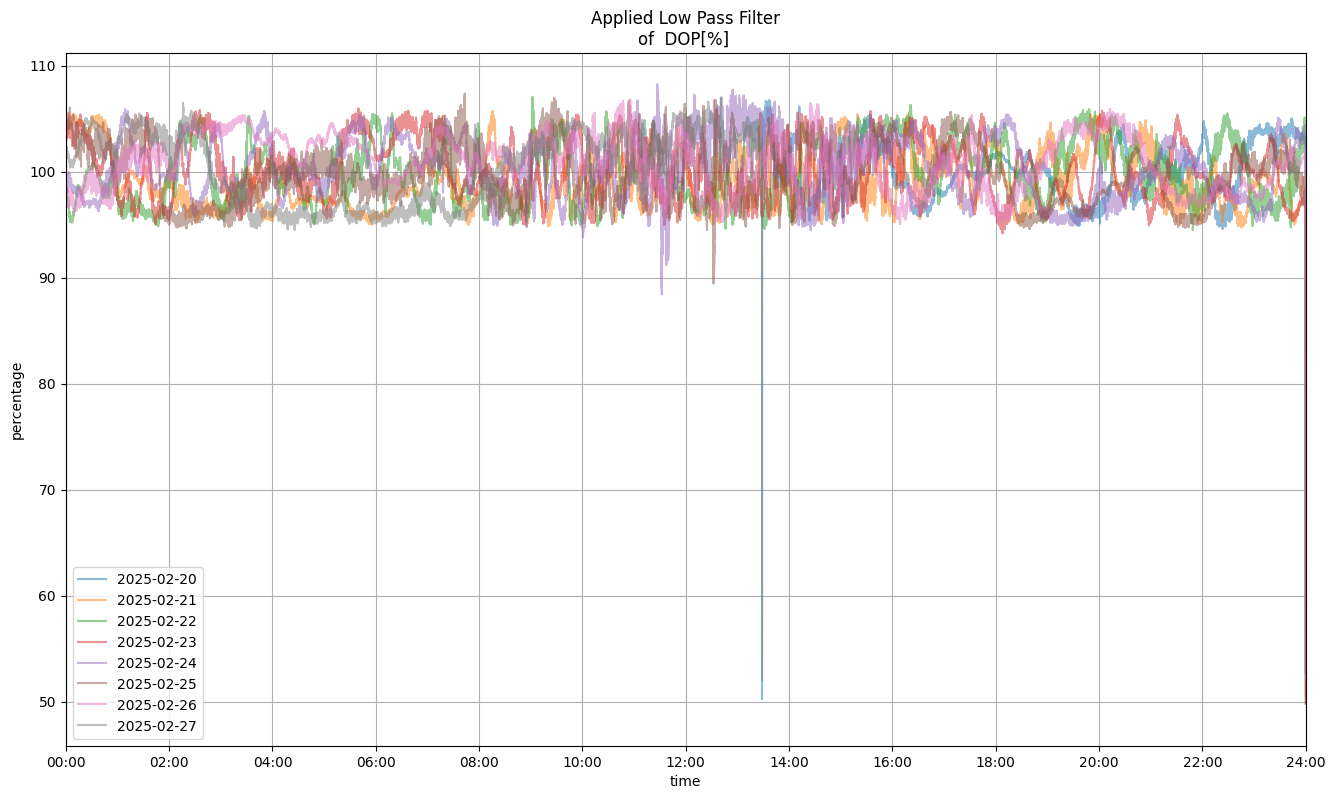

In [44]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day)
    lps = lowpass(ydata, 100)
    plt.plot(times, lps[:-1], label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter\nof {columns[11]}')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

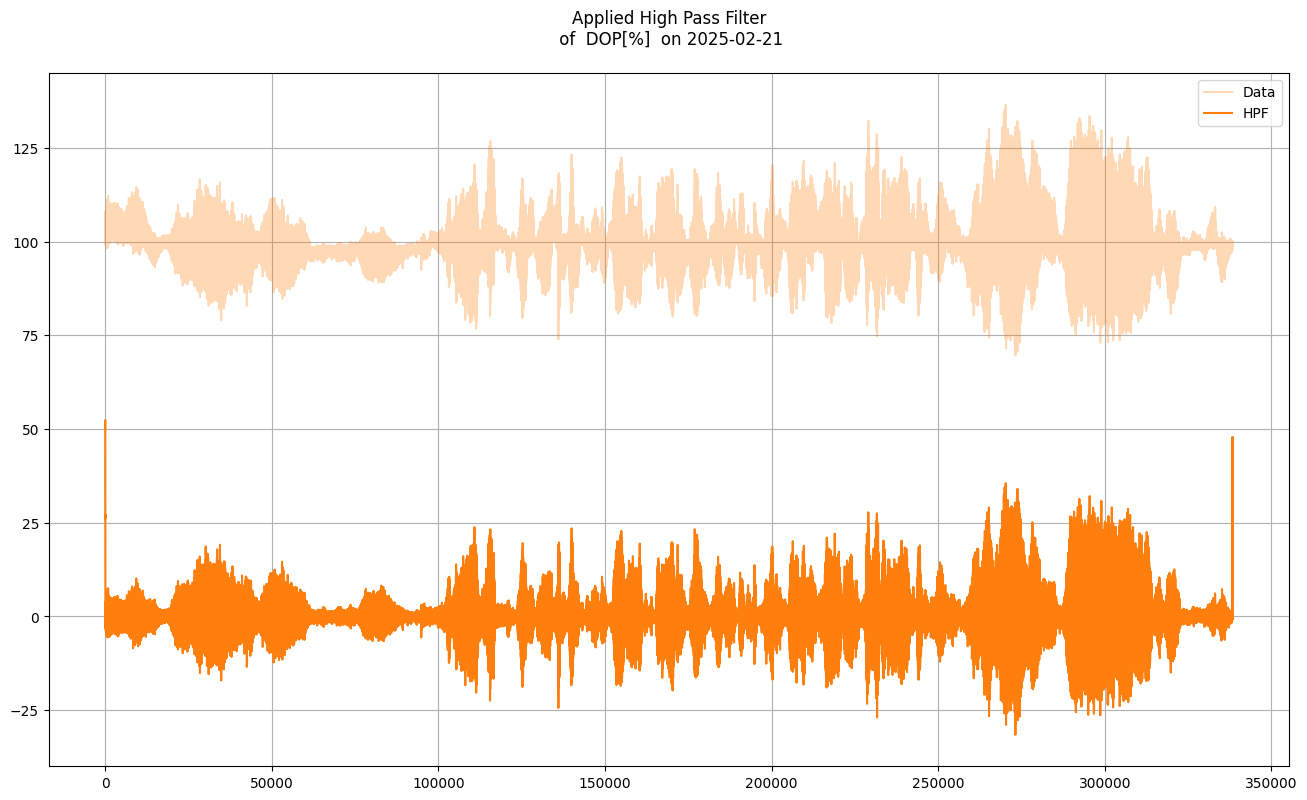

In [45]:
ydata = np.array(new_degree_daily_list[day][1])

hps = highpass(ydata, 100)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color=colors[day], alpha=0.3)
plt.plot(hps, label = 'HPF', color=colors[day])
plt.title(f'Applied High Pass Filter\n of {columns[11]} on {new_degree_daily_list[day][0]}\n')
plt.grid()
plt.legend(loc = 'best')
plt.show()

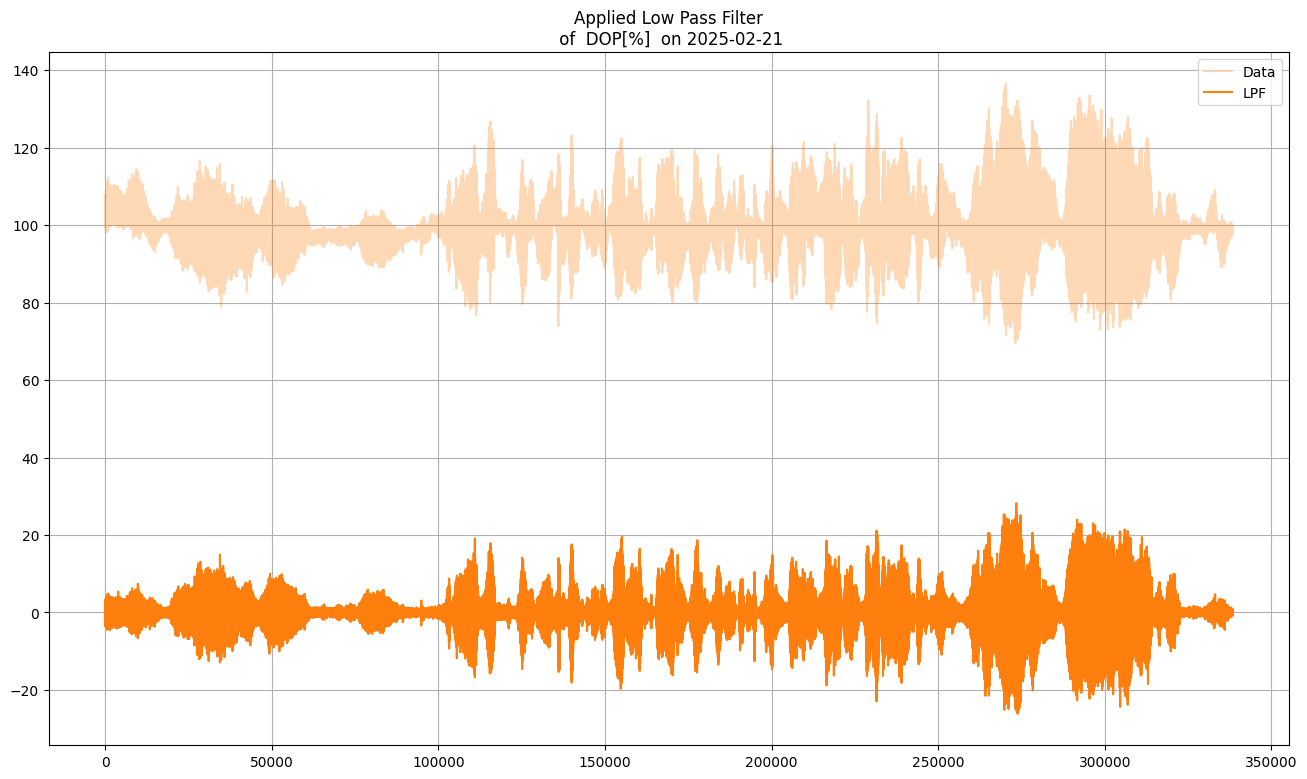

In [46]:
cutoff = 1.0
btype='high'

ydata = np.array(new_degree_daily_list[day][1])
lps = butter_filter(ydata, cutoff = cutoff, btype=btype)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(lps, label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter\n of {columns[11]} on {new_degree_daily_list[day][0]}')
plt.grid()
plt.legend(loc = 'best')
plt.show()

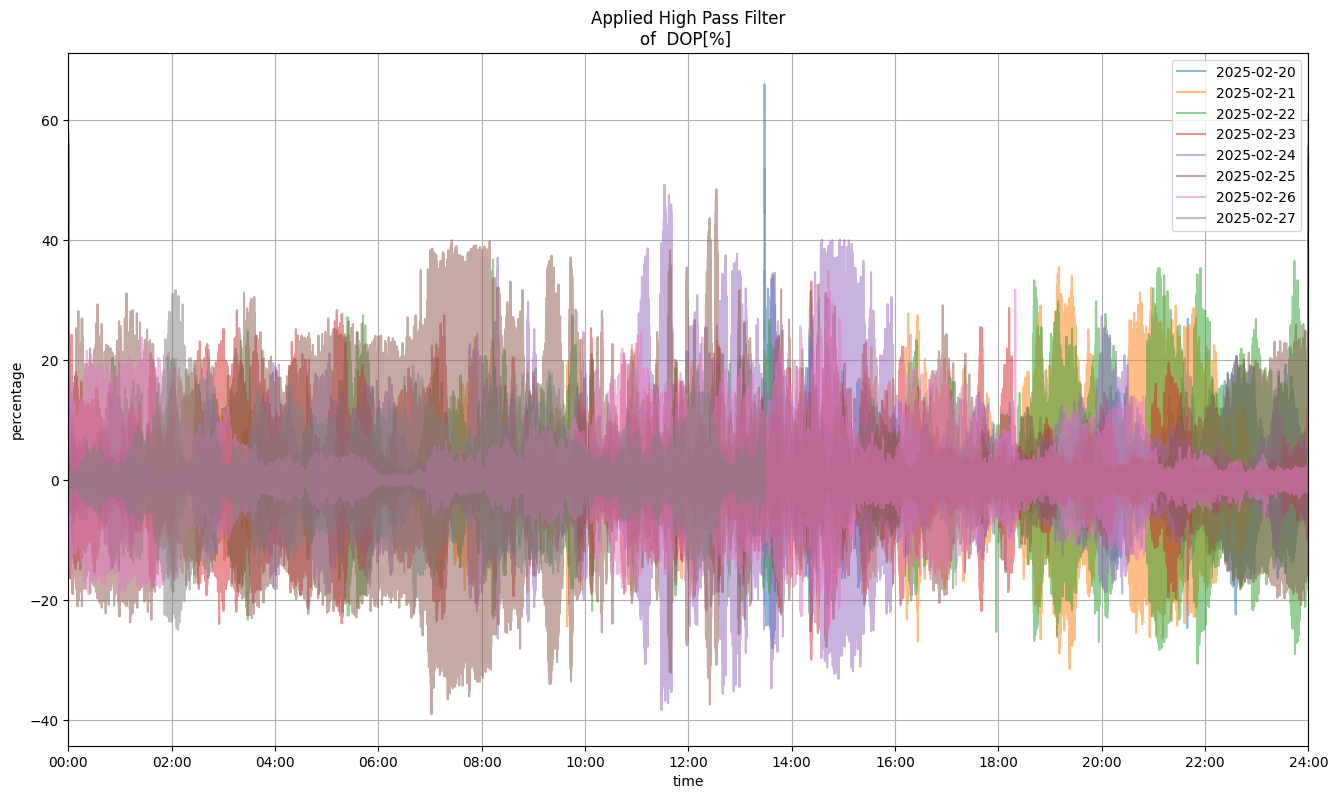

In [47]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day)
    hps = highpass(ydata, 100)
    plt.plot(times, hps, label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied High Pass Filter\nof {columns[11]}')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

# Winkelparameter (Azimut [°], Elliptizität [°])

In [48]:
angle = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[9], columns[10]])

In [49]:
angle[columns[0]] = pd.to_datetime(angle[columns[0]])
angle.set_index(columns[0], inplace=True)

## Tägliche Aufteilung der Messdaten

In [50]:
angle_daily = angle.groupby(angle.index.date)
angle_daily_list = list(angle_daily)

In [51]:
for date, df_day in angle_daily_list:
    print(date, '\n')
    print(df_day.describe())
    print('')

2025-02-20 

         Azimuth[°]   Ellipticity[°] 
count  148479.000000    148479.000000
mean       -2.877728        -1.448010
std        46.737623        19.713427
min       -90.000000       -44.790000
25%       -35.800000       -16.770000
50%        -4.210000        -2.760000
75%        30.190000        12.230000
max        90.000000        44.920000

2025-02-21 

         Azimuth[°]   Ellipticity[°] 
count  338320.000000    338320.000000
mean       13.072056         0.313493
std        45.974164        20.598256
min       -90.000000       -44.940000
25%       -15.320000       -16.080000
50%        19.500000        -0.920000
75%        46.960000        16.880000
max        90.000000        44.900000

2025-02-22 

         Azimuth[°]   Ellipticity[°] 
count  338429.000000    338429.000000
mean       -2.956018        -1.922901
std        48.328637        19.591658
min       -90.000000       -44.940000
25%       -46.530000       -17.030000
50%        -0.050000        -1.860000
75%      

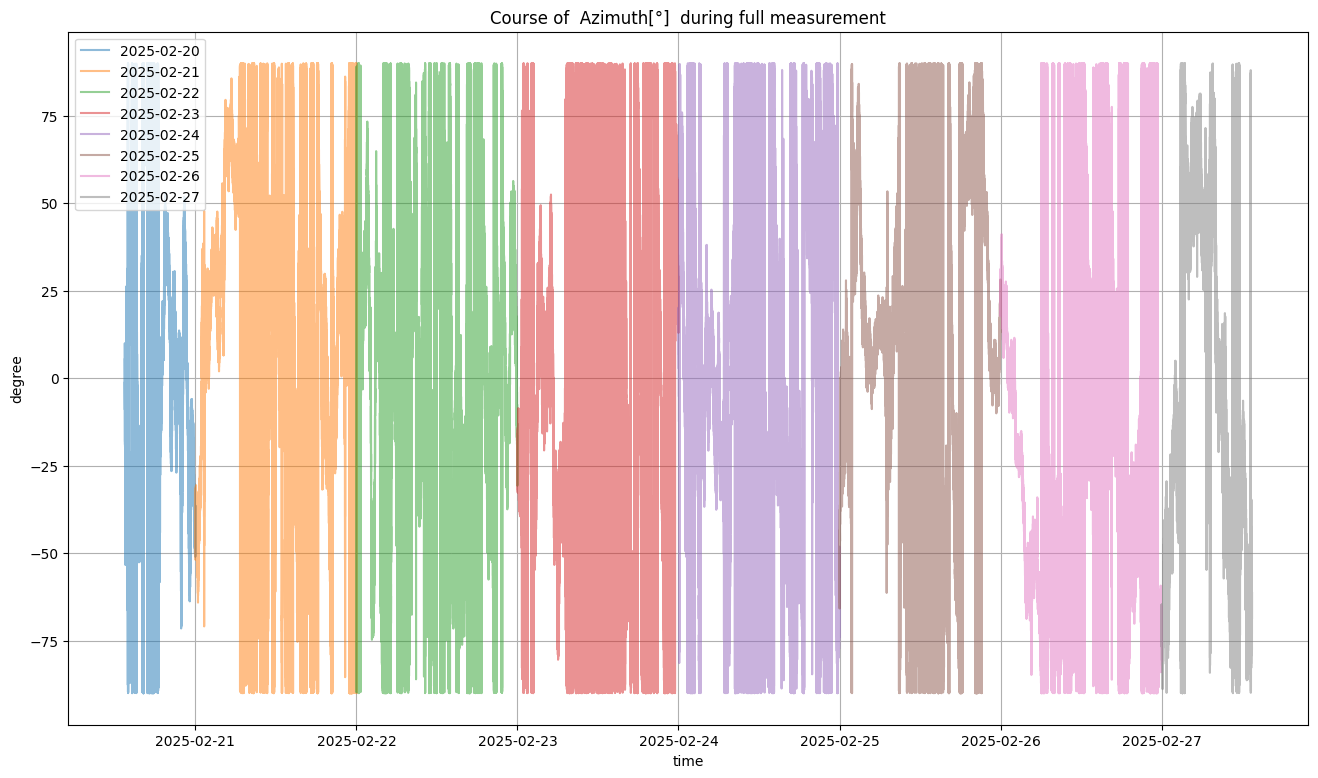

In [52]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    values = df_day[columns[9]]
    plt.plot(values, label=str(date), alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[9]} during full measurement')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

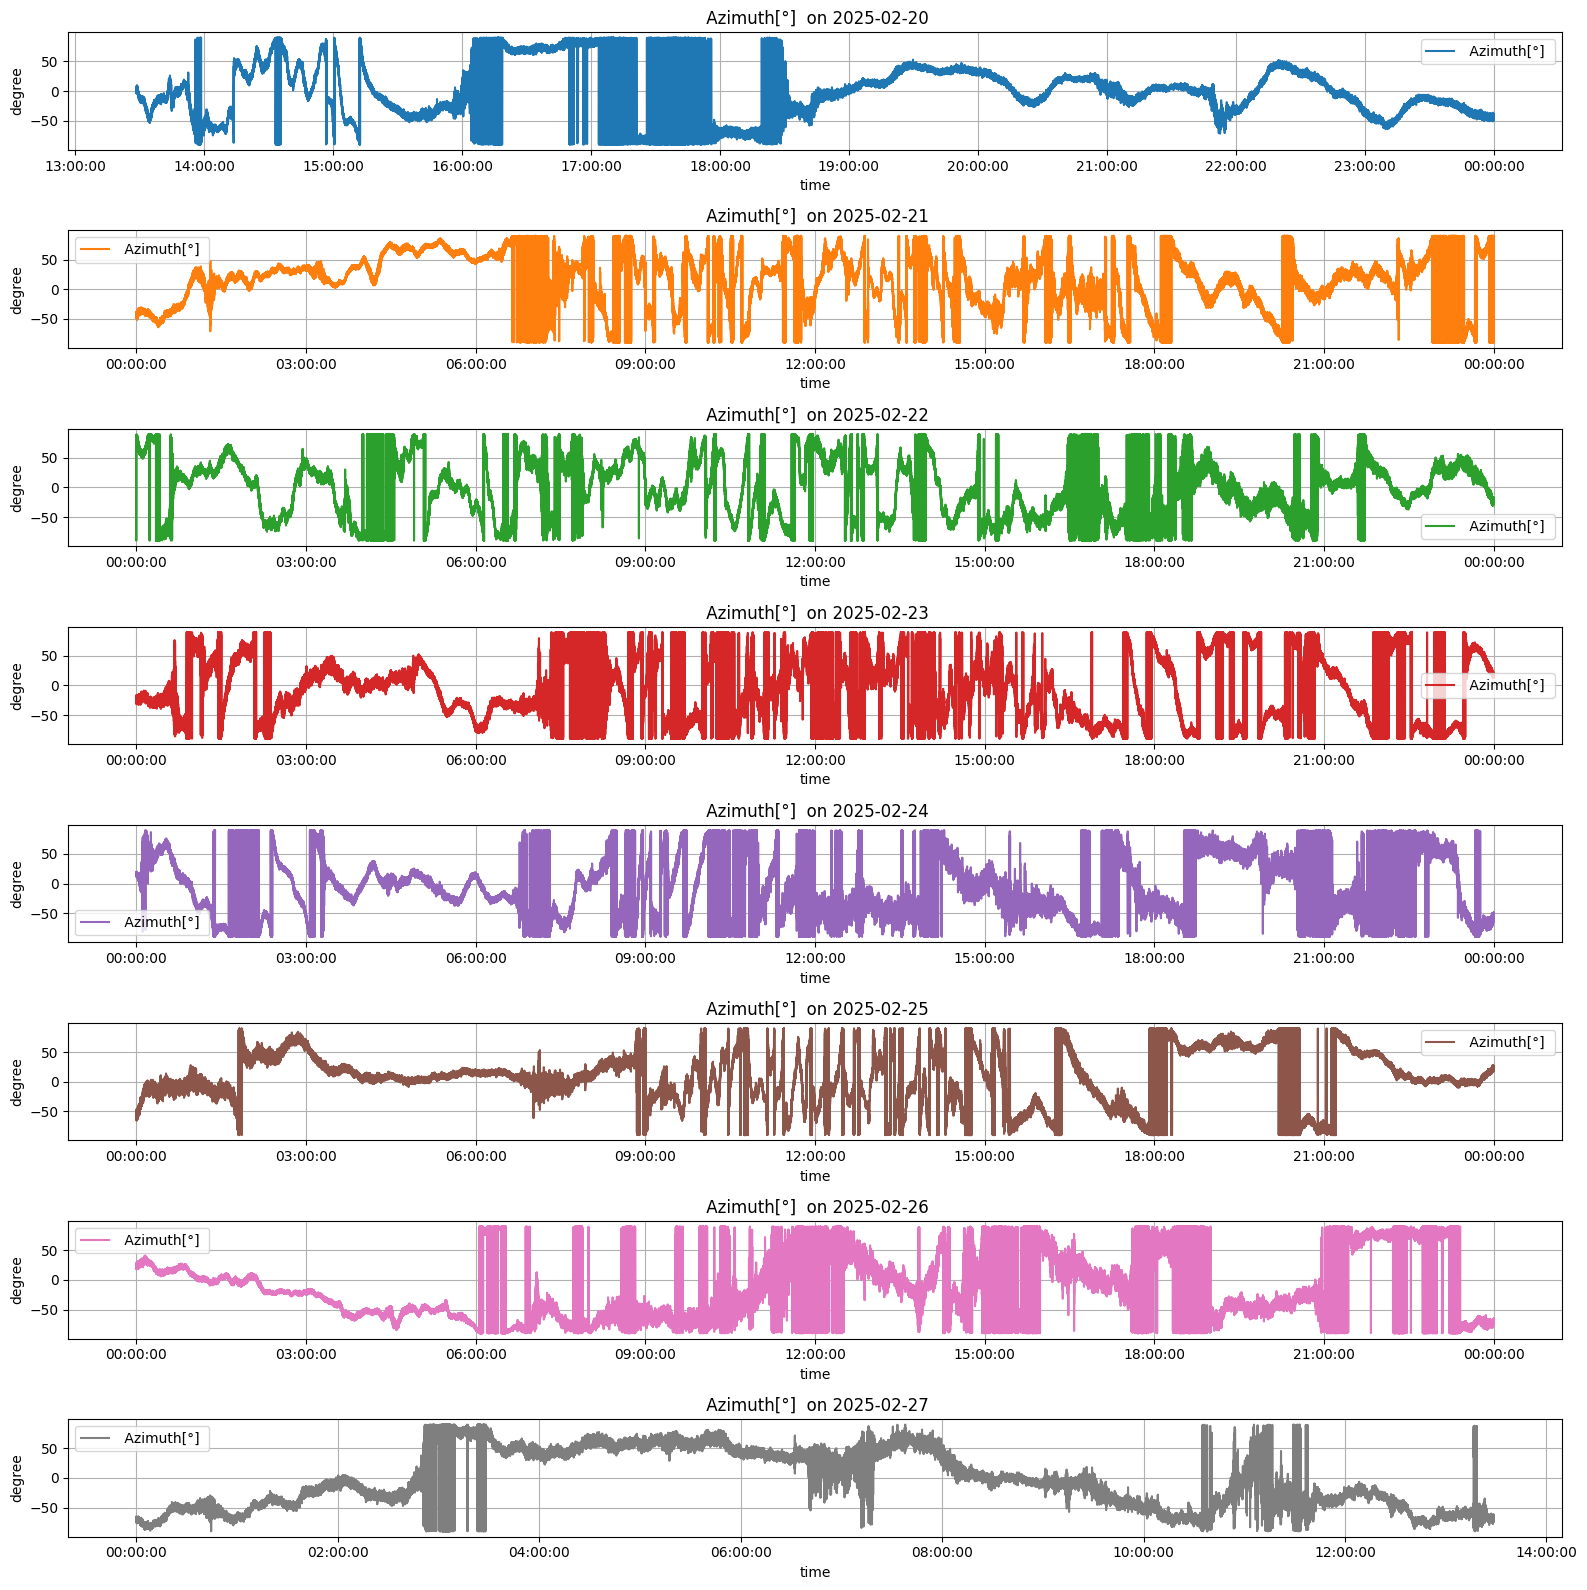

In [53]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[9]]

    ax.plot(df_day.index, df_day, label=columns[9], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[9]} on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

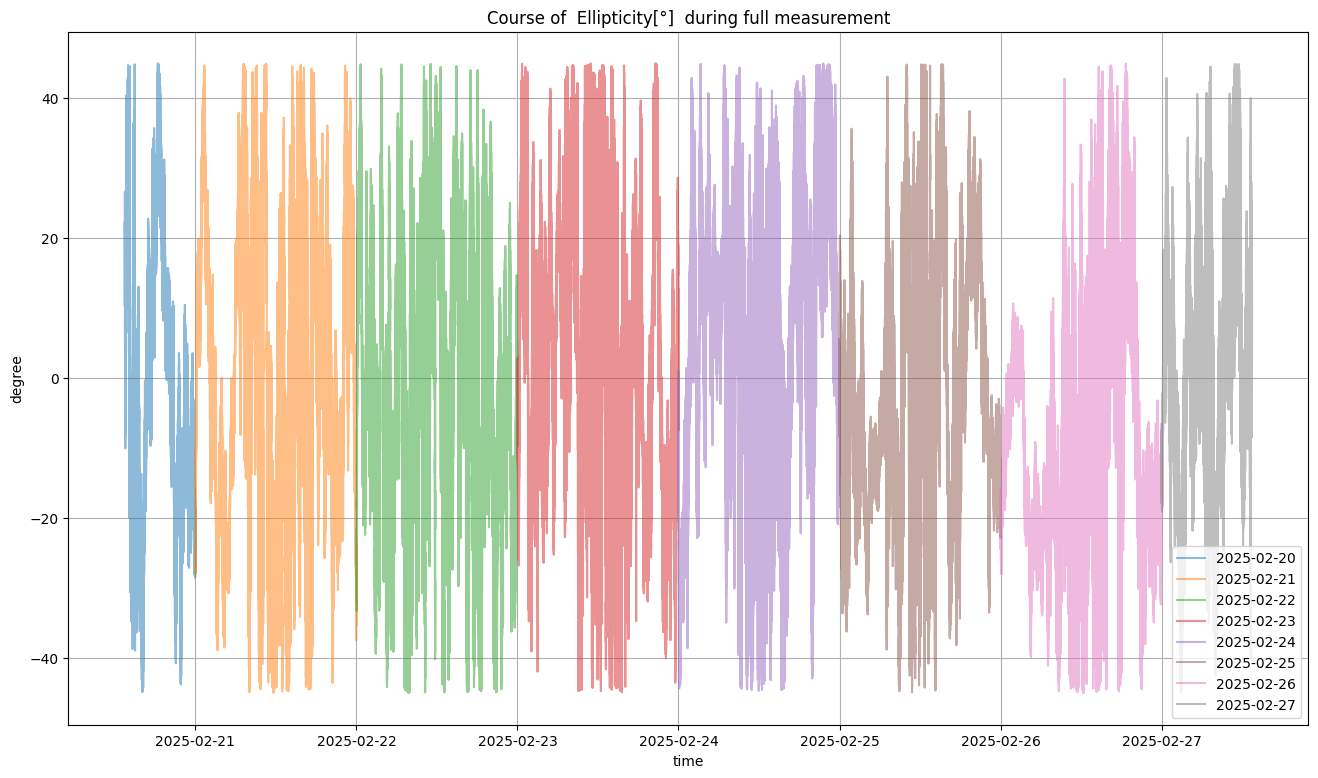

In [54]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    values = df_day[columns[10]]
    plt.plot(values, label=str(date), alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[10]} during full measurement')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

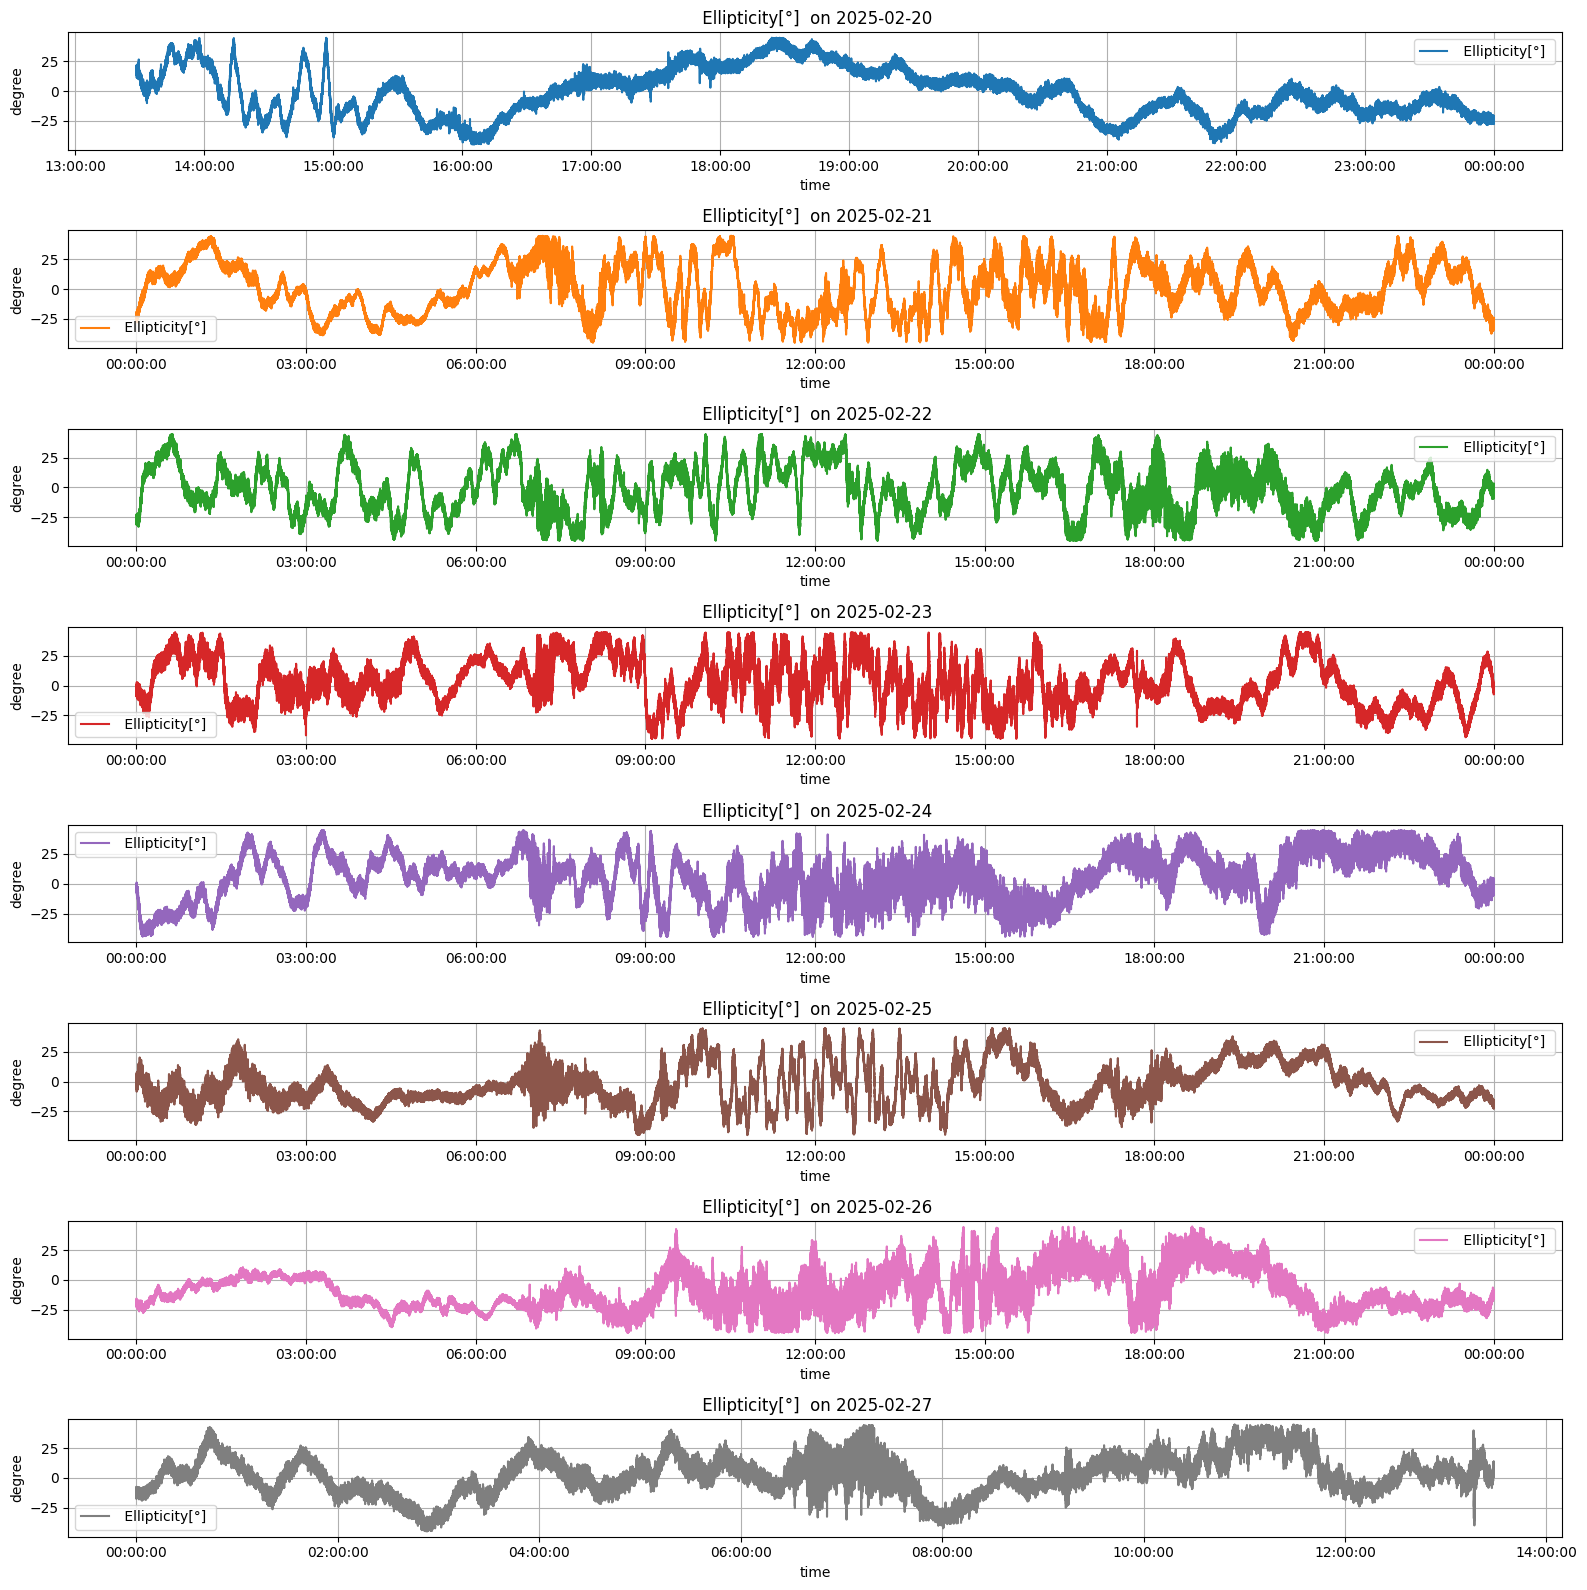

In [55]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]

    ax.plot(df_day.index, df_day, label=columns[10], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[10]} on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

## Tägliche Normalverteilung mit Histogramm

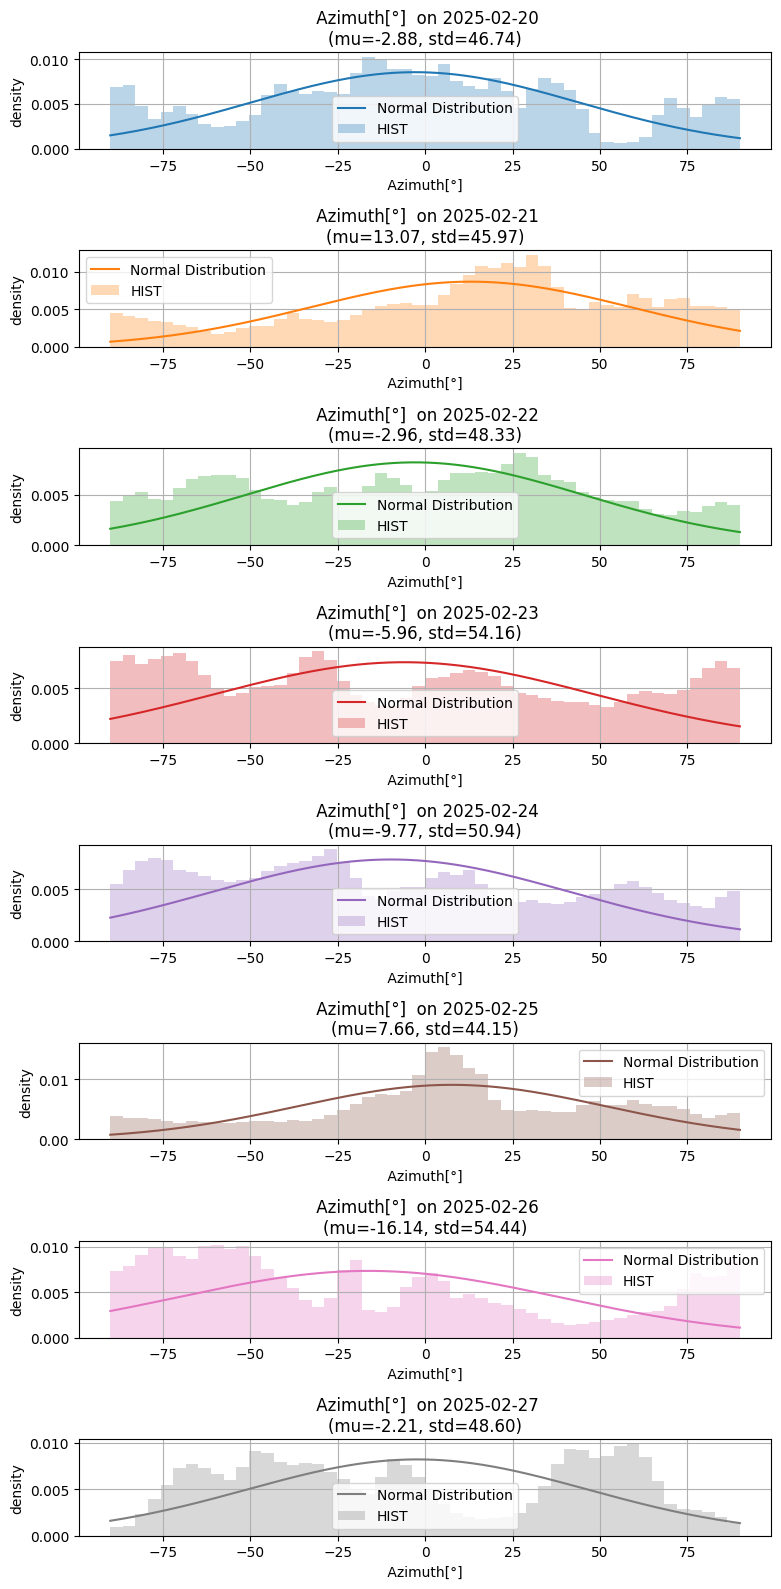

In [56]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    ydata1 = np.array(angle_daily_list[i][1][columns[9]])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[9]} on {angle_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[9])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

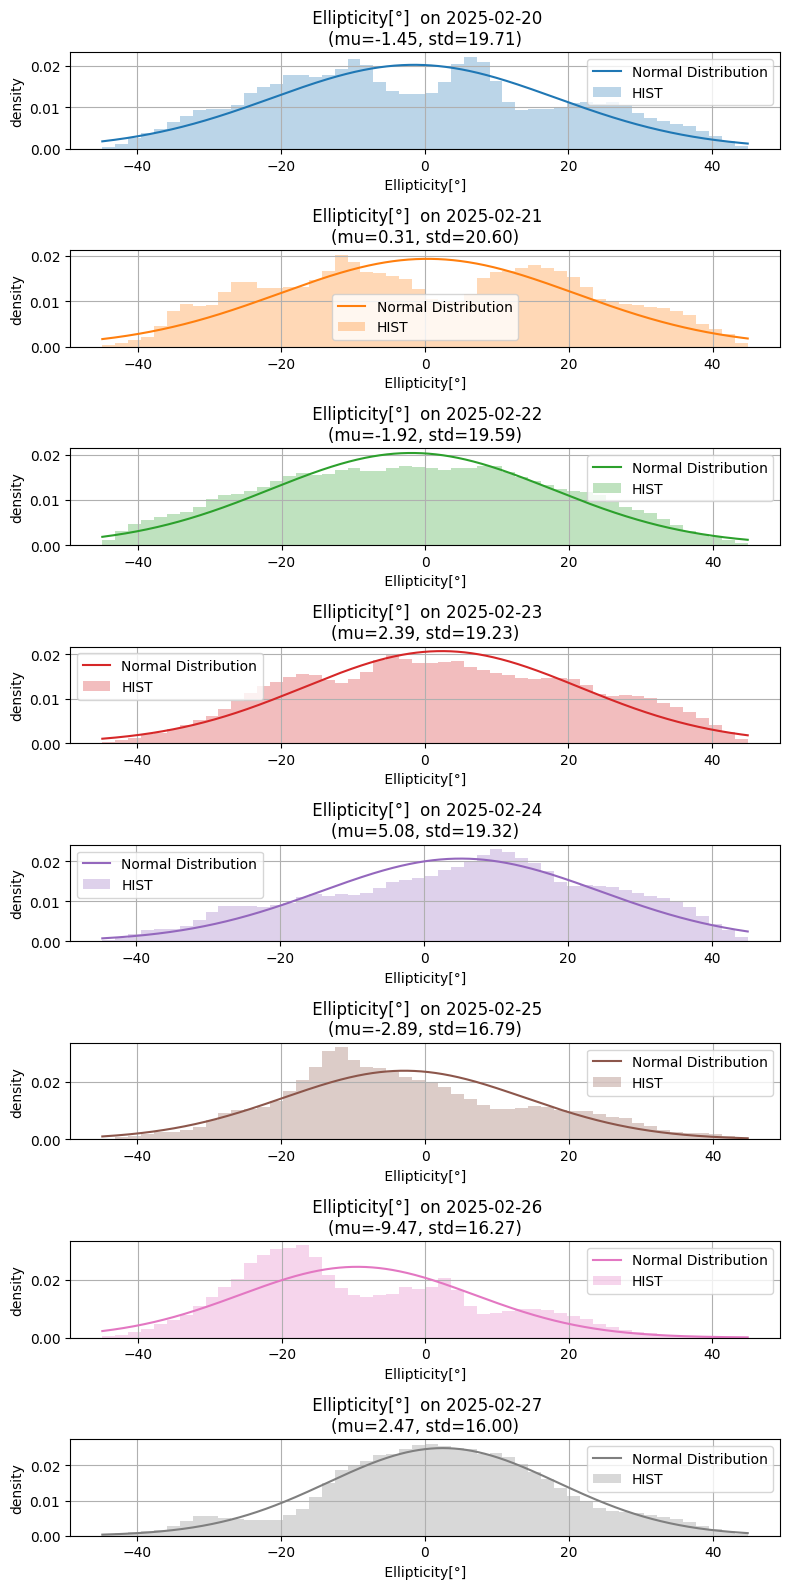

In [57]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    ydata1 = np.array(angle_daily_list[i][1][columns[10]])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[10]} on {angle_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[10])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

## Filterung mittels Tief- und Hochpass

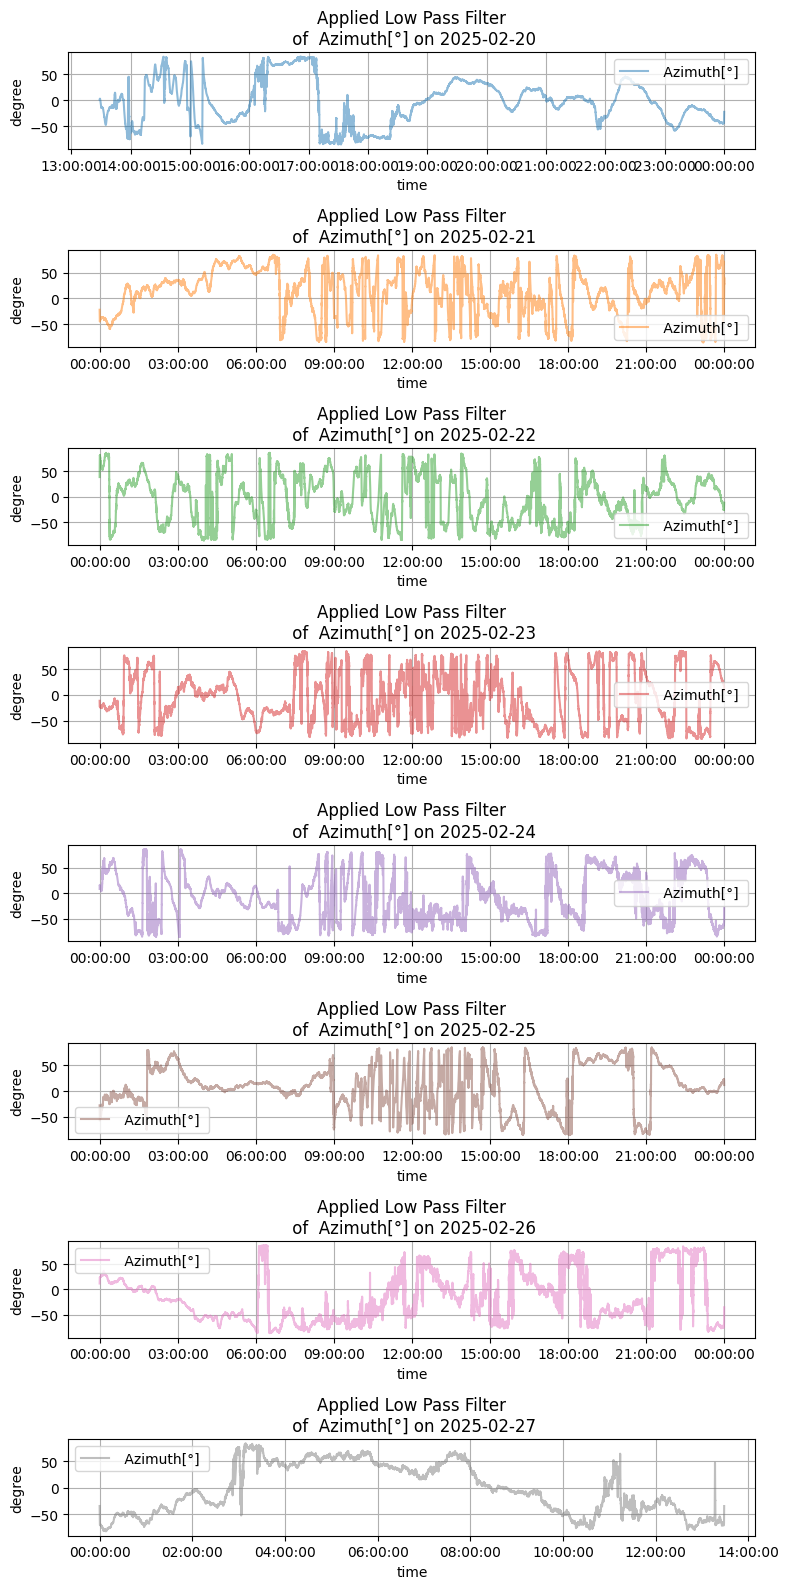

In [58]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[9]]
    ydata = np.array(df_day)
    lps = lowpass(ydata, 100)

    ax.plot(df_day.index, lps[:-1], label=columns[9], color=colors[i], alpha=0.5)
   
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied Low Pass Filter\n of {columns[9]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
        
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

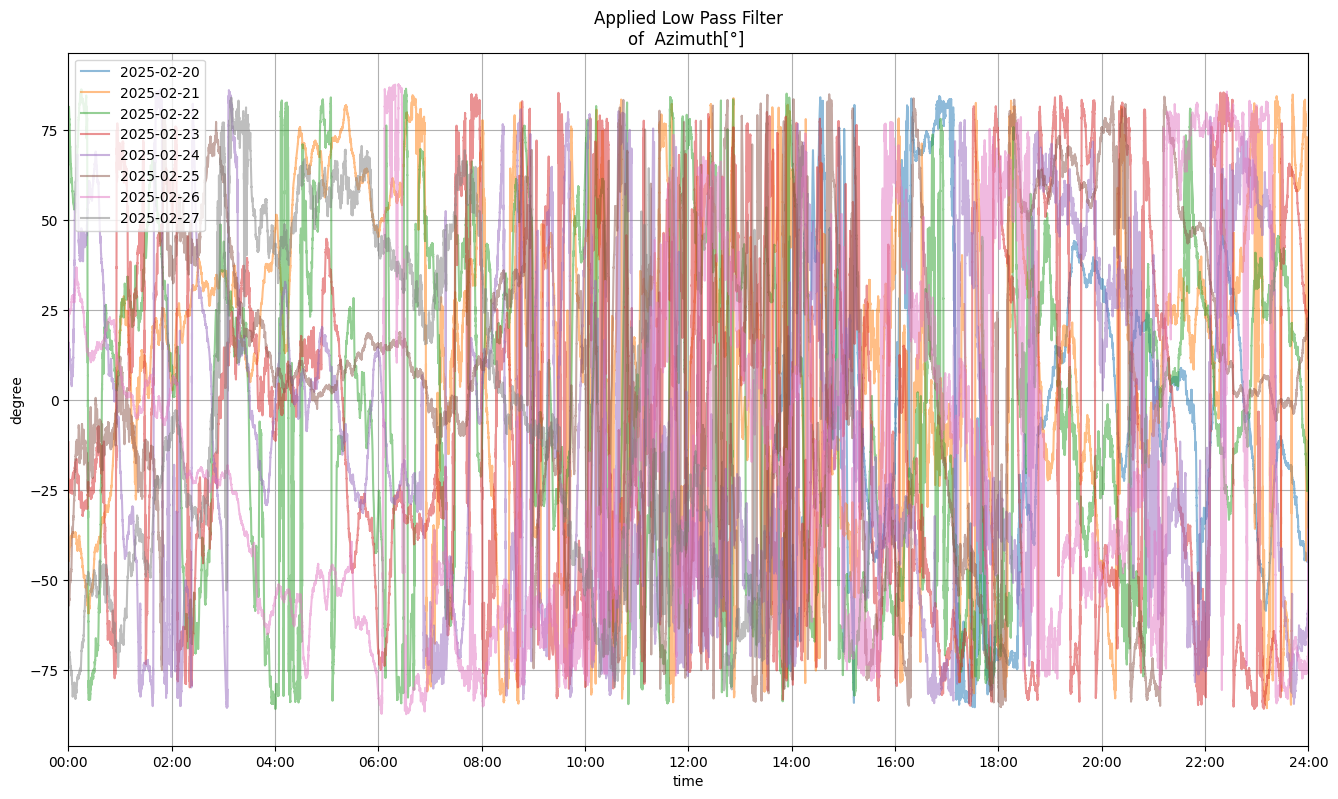

In [59]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in angle_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day[columns[9]])
    lps = lowpass(ydata, 100)
    plt.plot(times, lps[:-1], label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter\nof {columns[9]}')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

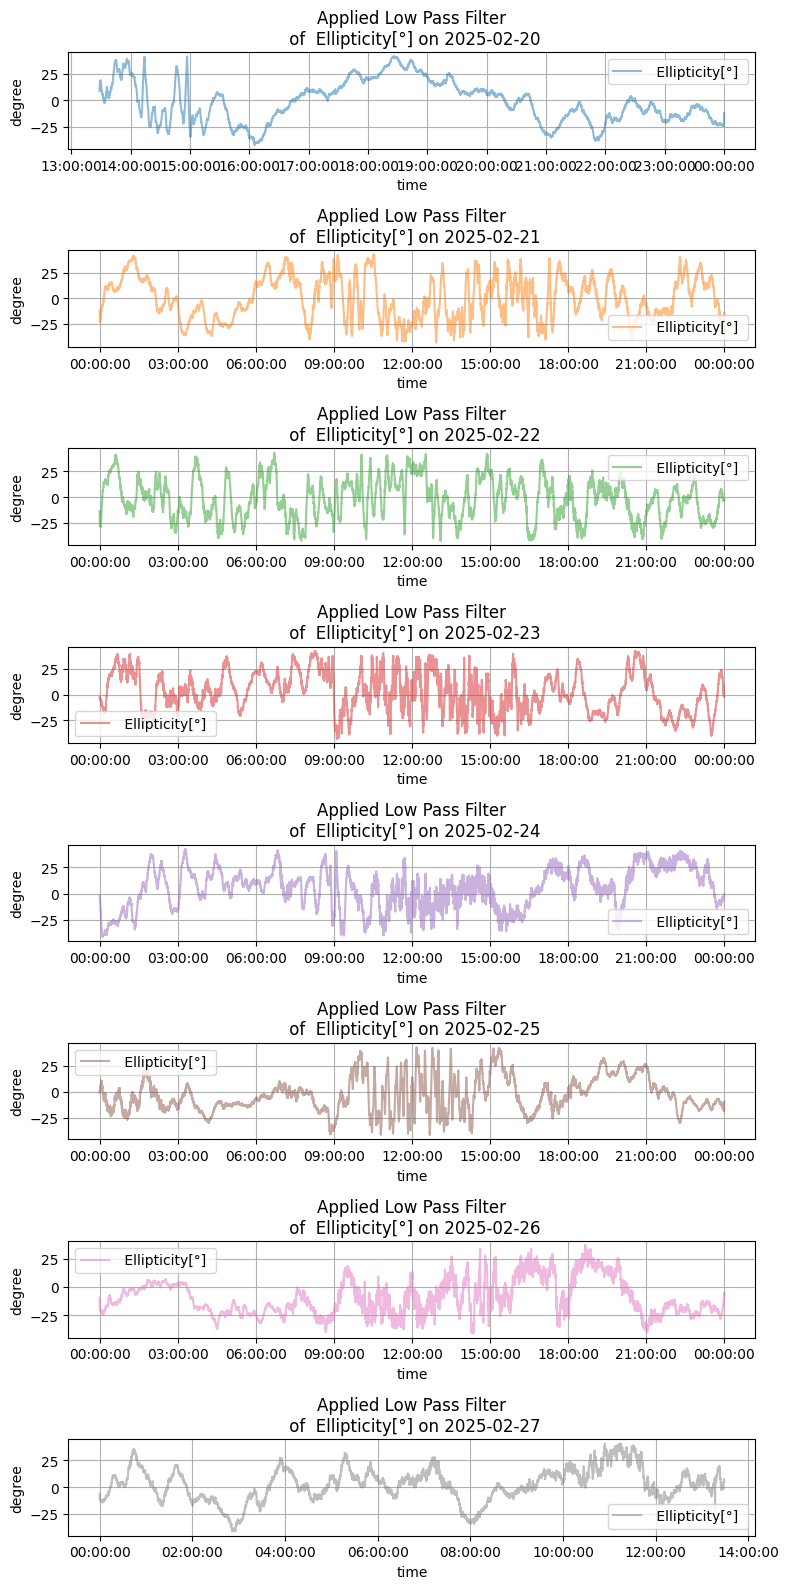

In [60]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]
    ydata = np.array(df_day)
    lps = lowpass(ydata, 100)

    ax.plot(df_day.index, lps[:-1], label=columns[10], color=colors[i], alpha=0.5)
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied Low Pass Filter\n of {columns[10]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

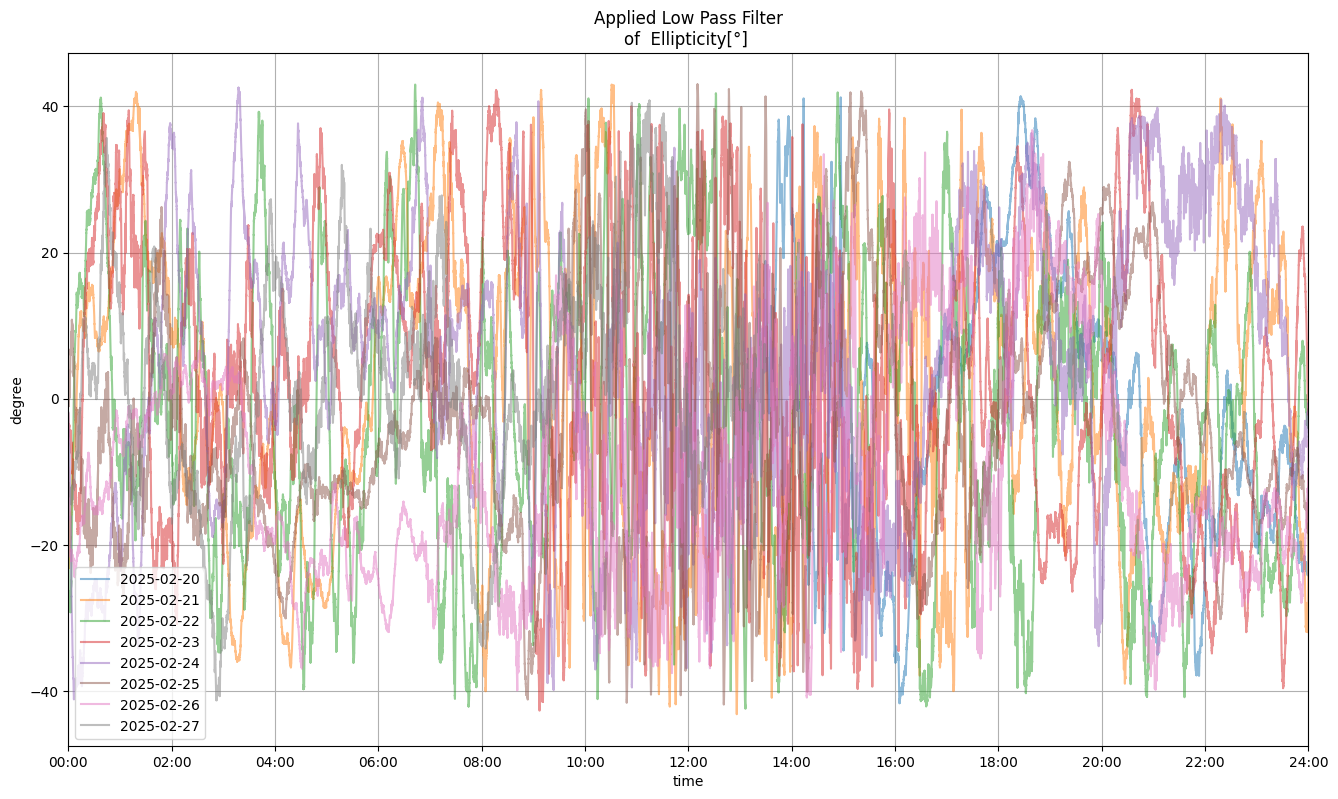

In [61]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in angle_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day[columns[10]])
    lps = lowpass(ydata, 100)
    plt.plot(times, lps[:-1], label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter\nof {columns[10]}')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

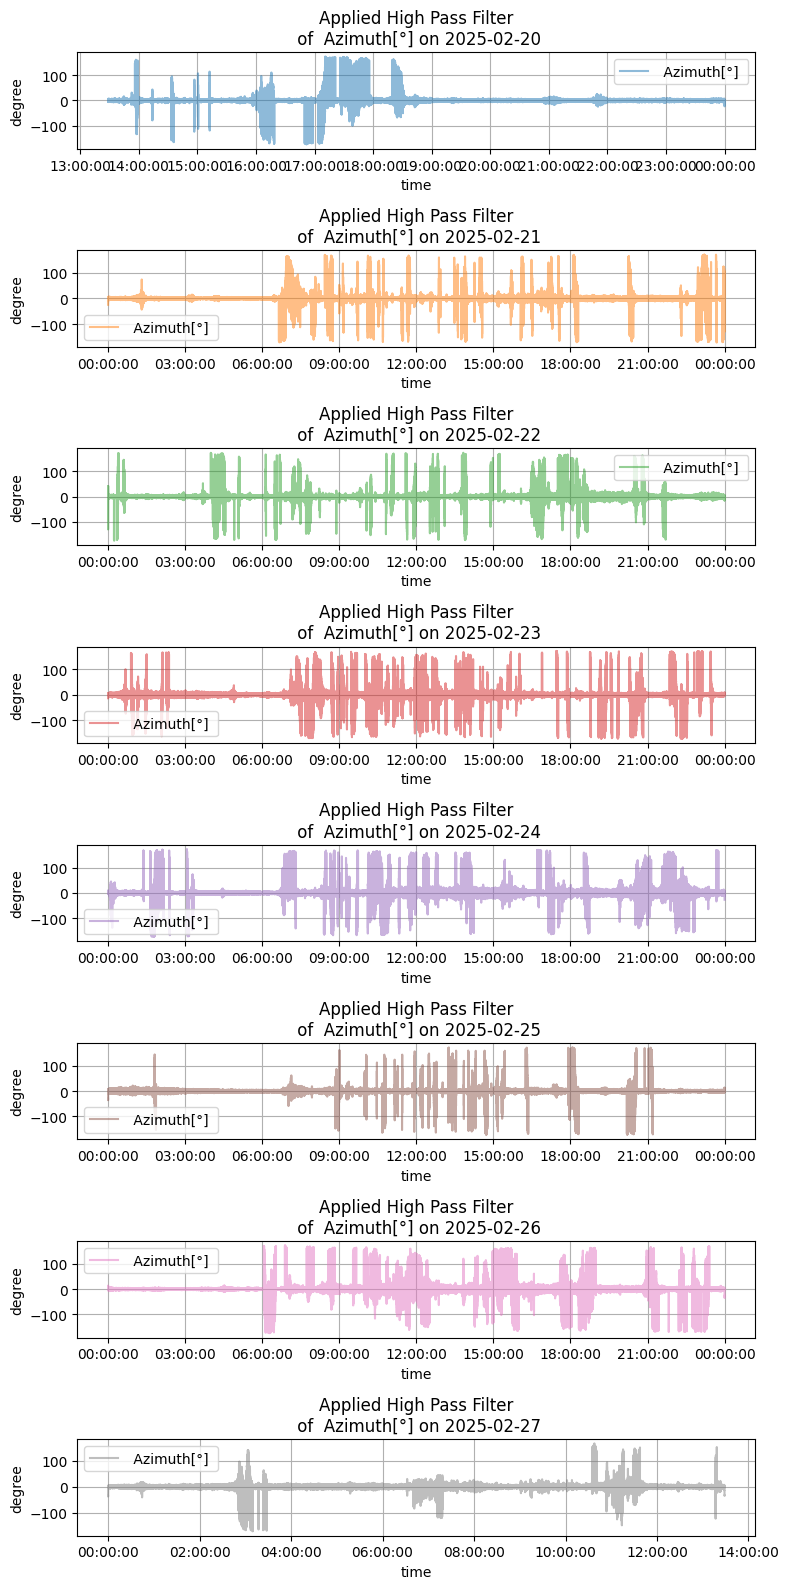

In [62]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[9]]
    ydata = np.array(df_day)
    hps = highpass(ydata, 100)

    ax.plot(df_day.index, hps, label=columns[9], color=colors[i], alpha=0.5)
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied High Pass Filter\n of {columns[9]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

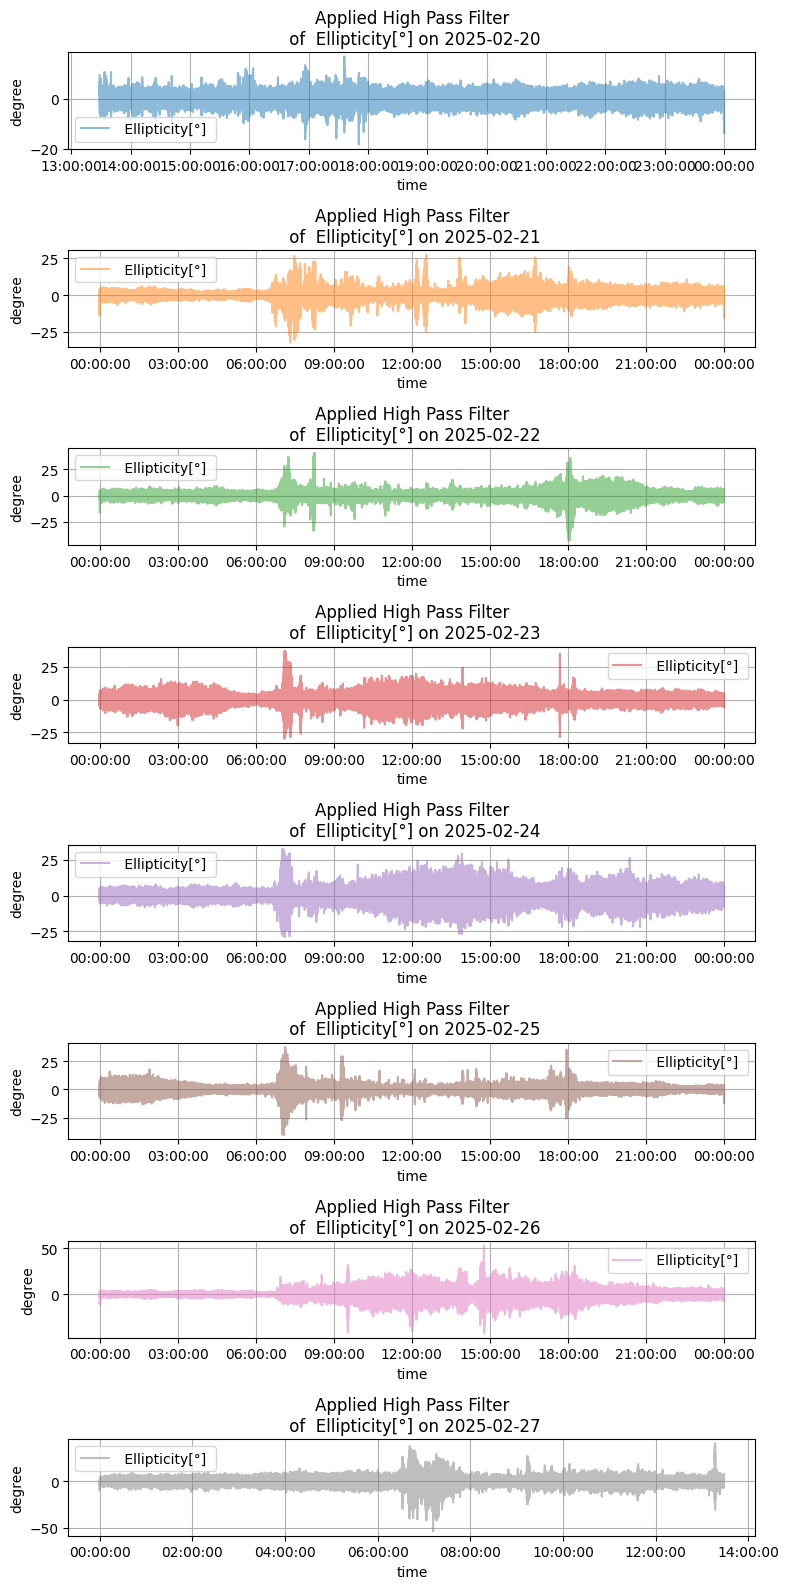

In [63]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]
    ydata = np.array(df_day)
    hps = highpass(ydata, 100)

    ax.plot(df_day.index, hps, label=columns[10], color=colors[i], alpha=0.5)
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied High Pass Filter\n of {columns[10]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

## Darstellung auf der Poincaré-Kugel
### Visualisierung mit dem Python-Tool [„py_pol“](https://py-pol.readthedocs.io/en/master/index.html)

In [64]:
one_second = datetime.timedelta(seconds=1)
one_minute = datetime.timedelta(minutes=1)
one_hour = datetime.timedelta(hours=1)
one_quater = datetime.timedelta(hours=6)
one_half = datetime.timedelta(hours=12)
one_day = datetime.timedelta(days=1)

start_time = datetime.datetime.strptime(str(angle.index[0]), '%Y-%m-%d %H:%M:%S.%f')
end_time_second = start_time + one_second
end_time_minute = start_time + one_minute
end_time_hour = start_time + one_hour
end_time_quater = start_time + one_quater
end_time_half = start_time + one_half
end_time_day = start_time + one_day

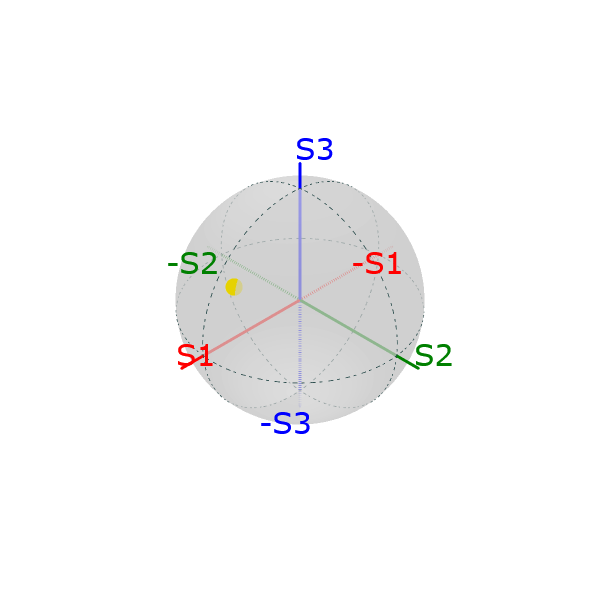

In [70]:
first_val = angle.iloc[0]

az = np.array(first_val[columns[9]]) * degrees
el = np.array(first_val[columns[10]]) * degrees

S = Stokes("Calculated Point")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_val.png")

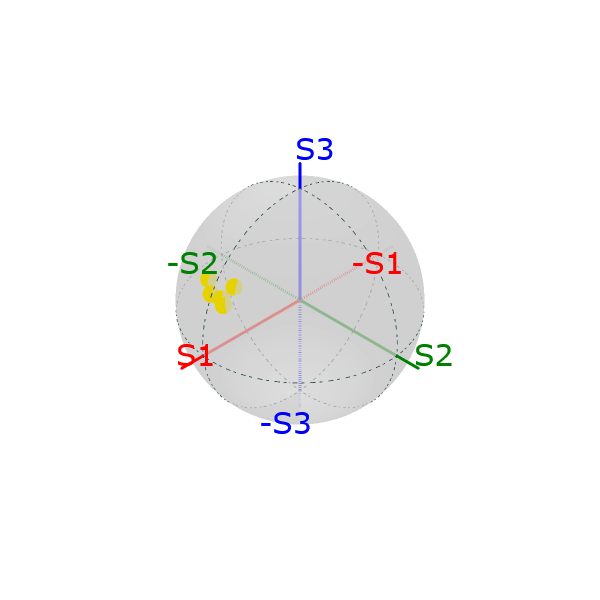

In [71]:
first_second = angle.loc[(angle.index >= start_time) & (angle.index < end_time_second)]

az = np.array(first_second[columns[9]].values) * degrees  
el = np.array(first_second[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_second.png")

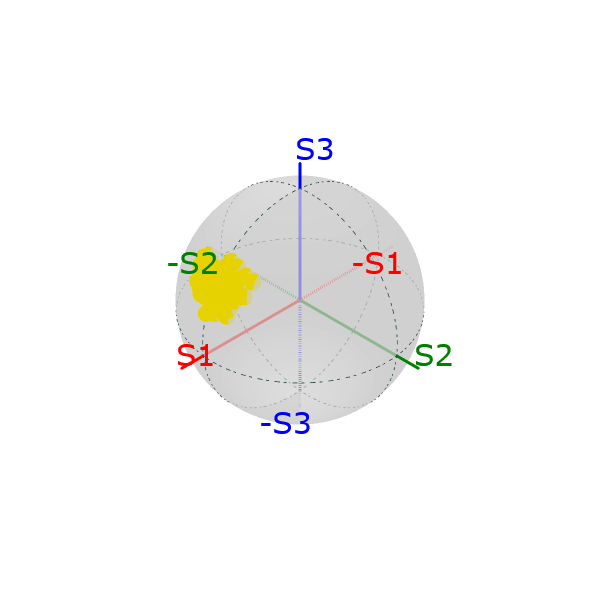

In [72]:
first_minute = angle.loc[(angle.index >= start_time) & (angle.index < end_time_minute)]

az = np.array(first_minute[columns[9]].values) * degrees
el = np.array(first_minute[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_minute.png")

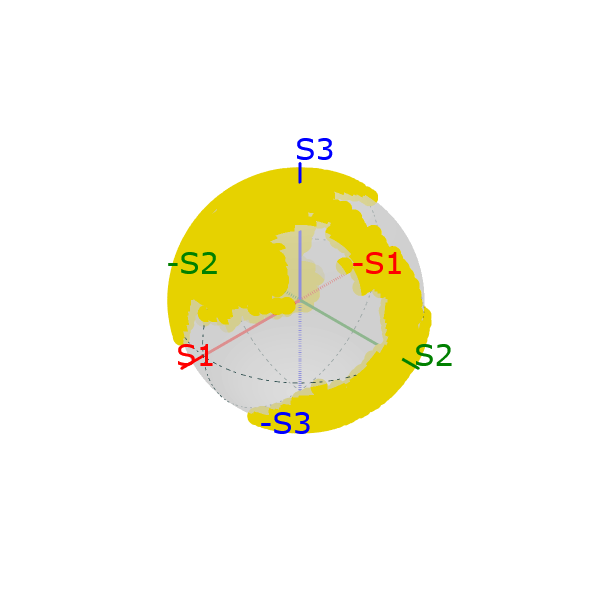

In [73]:
first_hour = angle.loc[(angle.index >= start_time) & (angle.index < end_time_hour)]

az = np.array(first_hour[columns[9]].values) * degrees
el = np.array(first_hour[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_hour.png")

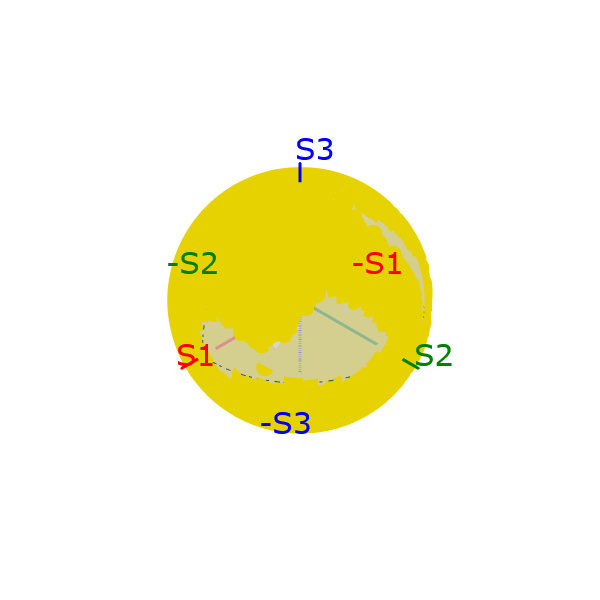

In [74]:
first_quater = angle.loc[(angle.index >= start_time) & (angle.index < end_time_quater)]

az = np.array(first_quater[columns[9]].values) * degrees
el = np.array(first_quater[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_quater.png")

### Eigene Berechnung und Visualisierung der Daten

In [76]:
normalized_stokes = pd.read_csv(filename,skiprows=skip, usecols=[columns[2], columns[3], columns[4]], sep=sep, nrows=5)
x,y,z = convert_angel(first_second[columns[9]].values, first_second[columns[10]].values)

data = pd.DataFrame({
    "S1": x,
    "Normalized S1": normalized_stokes[columns[2]],
    "S2": y,
    "Normalized S2": normalized_stokes[columns[3]],
    "S3": z,
    "Normalized S3": normalized_stokes[columns[4]]
})
print(data)

         S1  Normalized S1        S2  Normalized S2        S3  Normalized S3
0  0.796095           0.80  0.151863           0.15  0.585807           0.59
1  0.874517           0.87 -0.013433          -0.01  0.484810           0.48
2  0.879954           0.88  0.124923           0.12  0.458339           0.46
3  0.866366           0.87  0.090142           0.09  0.491208           0.49
4  0.828781           0.83 -0.088571          -0.09  0.552519           0.55


In [77]:
print("Original normalized S1 equals calculated S1? ", data['Normalized S1'].equals(round(data['S1'], 2)))
print("Original normalized S2 equals calculated S2? ", data['Normalized S2'].equals(round(data['S2'], 2)))
print("Original normalized S3 equals calculated S3? ", data['Normalized S3'].equals(round(data['S3'], 2)))

Original normalized S1 equals calculated S1?  True
Original normalized S2 equals calculated S2?  True
Original normalized S3 equals calculated S3?  True


In [78]:
#%matplotlib notebook # interaktiver Plot-Mode
%matplotlib inline # statischer Plot-Mode

UsageError: unrecognized arguments: # statischer Plot-Mode


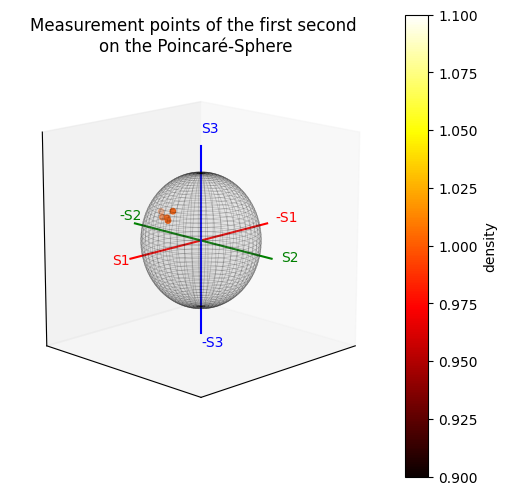

In [79]:
title = 'Measurement points of the first second \non the Poincaré-Sphere'
x,y,z = convert_angel(first_second[columns[9]].values, first_second[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

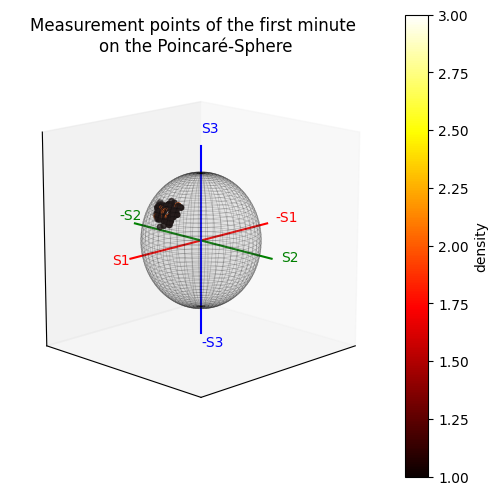

In [80]:
title = 'Measurement points of the first minute \non the Poincaré-Sphere'
x,y,z = convert_angel(first_minute[columns[9]].values, first_minute[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

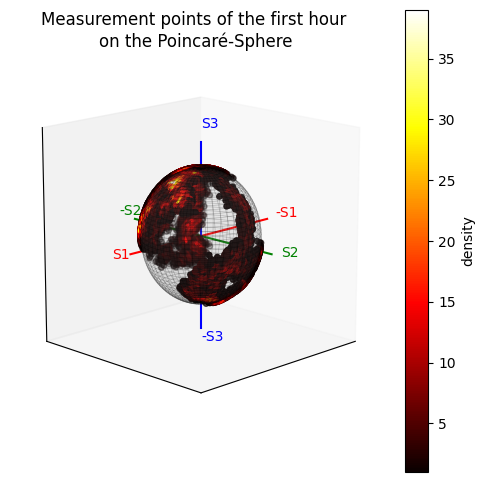

In [81]:
title = 'Measurement points of the first hour \non the Poincaré-Sphere'
x,y,z = convert_angel(first_hour[columns[9]].values, first_hour[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

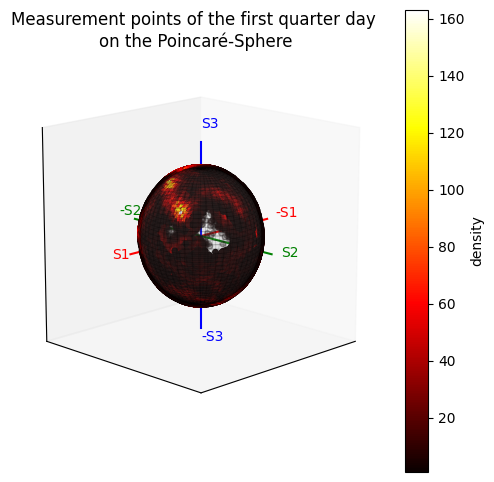

In [82]:
title = 'Measurement points of the first quarter day \non the Poincaré-Sphere'
x,y,z = convert_angel(first_quater[columns[9]].values, first_quater[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

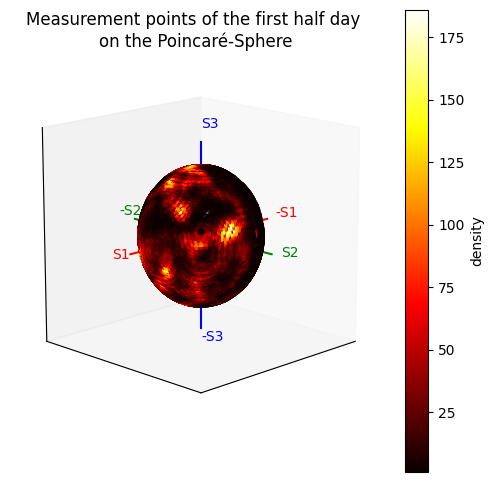

In [83]:
first_half = angle.loc[(angle.index >= start_time) & (angle.index < end_time_half)]

title = 'Measurement points of the first half day \non the Poincaré-Sphere'
x,y,z = convert_angel(first_half[columns[9]].values, first_half[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

In [84]:
angle_seconds_resample = angle.resample('s').mean().ffill()
angle_seconds_resample.head()

Azimuth[°]   Ellipticity[°] 
Time[date hh:mm:ss]                               
2025-02-20 13:28:29      3.000000        15.356667
2025-02-20 13:28:30      1.072500        16.080000
2025-02-20 13:28:31     -0.640000        15.827500
2025-02-20 13:28:32     -0.456667        15.610000
2025-02-20 13:28:33      3.132500        17.012500

In [85]:
print(angle_seconds_resample.isnull().sum())
print(type(angle.index))

Azimuth[°]         0
Ellipticity[°]     0
dtype: int64
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


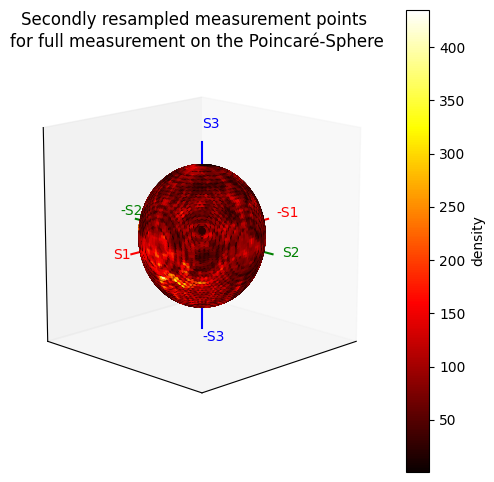

In [86]:
title= 'Secondly resampled measurement points \nfor full measurement on the Poincaré-Sphere'

x,y,z = convert_angel(angle_seconds_resample[columns[9]].values, angle_seconds_resample[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

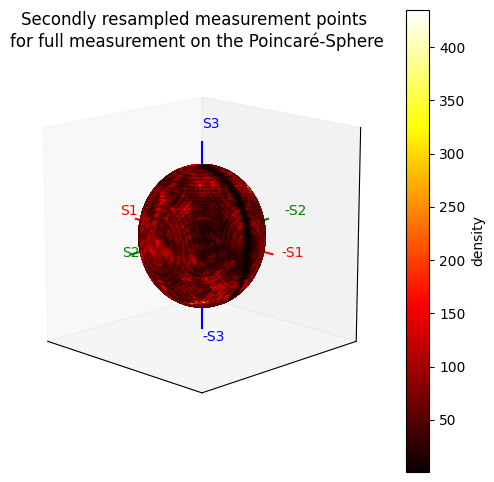

In [87]:
#elev=15, azim=45
title= 'Secondly resampled measurement points \nfor full measurement on the Poincaré-Sphere'
plot_poincare(x, y, z, freq, elev=15, azim=135, title=title)

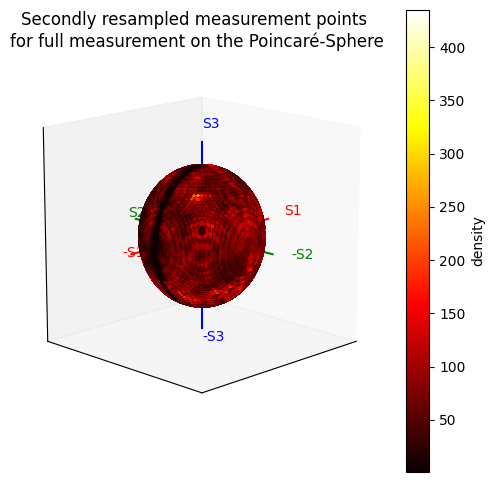

In [88]:
#elev=15, azim=45
title= 'Secondly resampled measurement points \nfor full measurement on the Poincaré-Sphere'
plot_poincare(x, y, z, freq, elev=15, azim=225, title=title)

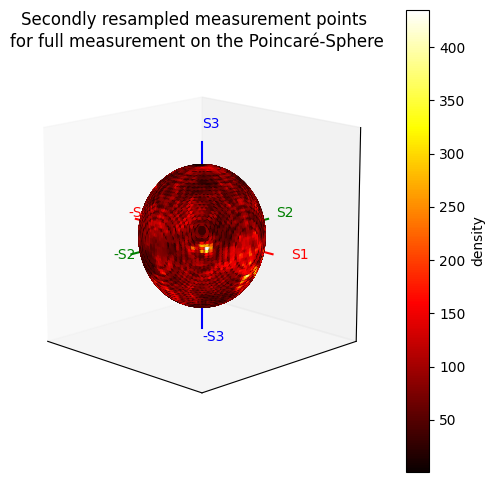

In [89]:
#elev=15, azim=45
title= 'Secondly resampled measurement points \nfor full measurement on the Poincaré-Sphere'
plot_poincare(x, y, z, freq, elev=15, azim=315, title=title)